In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
!pip install pmdarima
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
# Install the tslearn package
!pip install tslearn
import tslearn
print(tslearn.__version__)

In [ ]:

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

In [ ]:
import itertools

## **Usefull Functions for Analysis**

In [ ]:
def merge_imputed_data(tariff_data, missing_data):
    """
    Merges the imputed missing data with the original data and returns the combined DataFrame.

    Parameters:
    tariff_data (pd.DataFrame): The original DataFrame containing the consumption data with potential missing timestamps.
                             It must contain the columns 'LCLid', 'DateTime', and 'Consumption'.
    missing_data (pd.DataFrame): The DataFrame containing the imputed missing data. It must contain the columns
                                 'LCLid', 'MissingDateTime', and 'Consumption' along with 'Hour' and 'Month'.

    Returns:
    pd.DataFrame: A combined DataFrame with the original tariff data and the imputed missing data, sorted by 'LCLid' and 'DateTime'.
    """
    # Append MissingDateTime to original DateTime column in std_data to match the structure
    missing_data['DateTime'] = missing_data['MissingDateTime']
    missing_data = missing_data.drop(columns=['MissingDateTime', 'Hour', 'Month'])

    # Merge the imputed data back to the original std_data
    tariff_data_imputed = pd.concat([tariff_data, missing_data], ignore_index=True)
    tariff_data_imputed = tariff_data_imputed.sort_values(by=['LCLid', 'DateTime']).reset_index(drop=True)

    return tariff_data_imputed

In [ ]:
def identify_outliers_iqr(data):
    """
    Identifies outliers in the data based on IQR.

    Parameters:
    - data: DataFrame containing the 'TotalConsumption' column.

    Returns:
    - DataFrame with outliers.
    """
    Q1 = data['TotalConsumption'].quantile(0.25)
    Q3 = data['TotalConsumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['TotalConsumption'] < lower_bound) | (data['TotalConsumption'] > upper_bound)]
    return outliers

def plot_total_consumption_distribution(total_consumption, outliers, title):
    """
    Plots the distribution of total consumption values with outliers
    highlighted as legends.

    Parameters:
    - total_consumption: DataFrame containing LCLid and TotalConsumption
      columns for STD & ToU.
    - outliers: DataFrame containing LCLid and TotalConsumption of the outliers.
    - title: Title for the plot.

    The function uses a boxplot to visualize the distribution and includes legends for outliers
    for easy identification.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TotalConsumption', data=total_consumption)

    if not outliers.empty:
        # Create a color palette for the legends
        unique_outliers = outliers.drop_duplicates(subset=['LCLid'])
        print(f"Unique outliers:\n{unique_outliers}")

        palette = sns.color_palette("hsv", len(unique_outliers))

        # Plot legends for each unique outlier LCLid
        handles = []
        for i in range(unique_outliers.shape[0]):
            handles.append(plt.Line2D([0], [0], marker='o', color='w', label=unique_outliers.iloc[i]['LCLid'],
                                      markerfacecolor=palette[i], markersize=10))

        plt.legend(title='Outlier LCLid', handles=handles)

    plt.title(title)
    plt.xlabel('Total Consumption')
    plt.show()

    if not outliers.empty:
        return unique_outliers[['LCLid']].reset_index(drop=True)
    else:
        return None

In [ ]:
def plot_monthly_consumption(std_data_clean, tou_data_clean):
    """
    This function plots a line graph comparing the sum of consumption grouped by month
    for the year 2013 from two data frames: std_data_clean and tou_data_clean.

    Parameters:
    std_data_clean (DataFrame): The first data frame containing the standard data.
    tou_data_clean (DataFrame): The second data frame containing the time-of-use data.

    Returns:None
    """
    # Converting DateTime column to datetime type
    std_data_clean['DateTime'] = pd.to_datetime(std_data_clean['DateTime'])
    tou_data_clean['DateTime'] = pd.to_datetime(tou_data_clean['DateTime'])

    # Filtering data for the year 2013
    std_2013 = std_data_clean[std_data_clean['DateTime'].dt.year == 2013]
    tou_2013 = tou_data_clean[tou_data_clean['DateTime'].dt.year == 2013]

    # Grouping by month and summing the Consumption
    std_monthly_consumption = std_2013.groupby(std_2013['DateTime'].dt.month)['Consumption'].sum()
    tou_monthly_consumption = tou_2013.groupby(tou_2013['DateTime'].dt.month)['Consumption'].sum()

    # Plotting the line graph
    plt.figure(figsize=(10, 6))
    plt.plot(std_monthly_consumption.index, std_monthly_consumption.values, label='STD Data', marker='o')
    plt.plot(tou_monthly_consumption.index, tou_monthly_consumption.values, label='TOU Data', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Total Consumption')
    plt.title('Monthly Consumption for Year 2013')
    plt.legend()
    plt.grid(True)
    plt.figtext(0.5, -0.1, 'Figure 1: Comparison of monthly consumption for the year 2013 between STD and TOU data.', ha='center', fontsize=10)
    plt.show()


In [ ]:
def convert_to_hourly(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    df_hourly = df.groupby('LCLid').resample('H').sum().reset_index()
    return df_hourly


In [ ]:
def normalize_time_series_data(input_df):
    """
    This function normalizes the time-series data (excluding the 'LCLid' and 'DateTime' columns)
    in the provided DataFrame using Min-Max scaling within each group defined by the 'LCLid' column.

    Parameters:
    input_df (pd.DataFrame): DataFrame containing the time-series data with 'LCLid' and 'DateTime' columns.

    Returns:
    pd.DataFrame: DataFrame with normalized time-series data.
    MinMaxScaler: The scaler object used for normalization.
    """
    # Group the data by the 'LCLid' column
    groups = input_df.groupby('LCLid')

    # Initialize a list to store the normalized groups and scalers
    normalized_groups = []
    scalers = []

    # Iterate over each group
    for name, group in groups:
        # Extract time-series columns (excluding the 'LCLid' and 'DateTime' columns)
        time_series_data = group.drop(columns=['LCLid', 'DateTime'])

        # Initialize the scaler
        scaler = MinMaxScaler()

        # Fit and transform the time-series data
        normalized_data = scaler.fit_transform(time_series_data)

        # Create a new DataFrame with the normalized data
        normalized_group = pd.DataFrame(normalized_data, columns=time_series_data.columns)

        # Add the 'LCLid' and 'DateTime' columns back
        normalized_group.insert(0, 'DateTime', group['DateTime'].values)
        normalized_group.insert(0, 'LCLid', group['LCLid'].values)

        # Append the normalized group and scaler to the lists
        normalized_groups.append(normalized_group)
        scalers.append((name, scaler))  # Store scaler with corresponding LCLid

    # Concatenate all normalized groups into a single DataFrame
    normalized_df = pd.concat(normalized_groups, ignore_index=True)

    return normalized_df, scalers

In [ ]:
def plot_average_day_comparison(std_df, tou_df, half_hour_intervals=48):
    """
    Plot the average day consumption for STD and ToU datasets, and the percentage difference between them.

    Parameters:
    std_df (pd.DataFrame): DataFrame containing the normalized and pivoted data for the STD dataset.
    tou_df (pd.DataFrame): DataFrame containing the normalized and pivoted data for the ToU dataset.
    half_hour_intervals (int): The number of half-hour intervals to display on the x-axis. Default is 48 (24 hours).
    """
    # Drop the LCLid column to focus on the time series data
    std_data = std_df.drop(columns=['LCLid']).iloc[:, :half_hour_intervals]
    tou_data = tou_df.drop(columns=['LCLid']).iloc[:, :half_hour_intervals]

    # Compute the average consumption for each half-hour interval
    std_mean = std_data.mean(axis=0)
    tou_mean = tou_data.mean(axis=0)

    # Compute the percentage difference
    percent_diff = ((std_mean - tou_mean) / tou_mean) * 100

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting mean consumption
    ax1.plot(std_mean.index, std_mean, color='black', label='STD average day')
    ax1.plot(tou_mean.index, tou_mean, color='orange', label='ToU dataset average day')
    ax1.set_xlabel('Half hour in day (0 = midnight)')
    ax1.set_ylabel('Mean % annual consumption in half hour')
    ax1.legend(loc='upper right')

    # Adding secondary axis for percentage difference
    ax2 = ax1.twinx()
    ax2.bar(std_mean.index, percent_diff, color='grey', alpha=0.5, label='% difference')
    ax2.set_ylabel('% difference between STD and ToU mean value in half hour')

    # Adjusting x-axis limits to the specified period
    ax1.set_xlim([0, half_hour_intervals - 1])

    # Adding a legend
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Adding title
    plt.title('STD average day compared with ToU average day')
    plt.show()

In [ ]:
def perform_pca(normalized_df, n_components=None):
    """
    Perform PCA on the normalized DataFrame and print explained variance and cumulative explained variance.

    Parameters:
    normalized_df (pd.DataFrame): DataFrame containing normalized time-series data.
    n_components (int or None): Number of PCA components to retain. If None, use min(n_samples, n_features).

    Returns:
    pd.DataFrame: PCA-transformed data as a DataFrame.
    """
    # Extract time-series data and identifiers
    identifiers = normalized_df.iloc[:, 0].values
    time_series_data = normalized_df.iloc[:, 1:].values

    # Determine the number of PCA components to use
    n_samples, n_features = time_series_data.shape
    if n_components is None:
        n_components = min(n_samples, n_features)

    # Ensure n_components is not greater than the number of features
    n_components = min(n_components, n_features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    time_series_data_pca = pca.fit_transform(time_series_data)

    # Print explained variance and cumulative explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()
    print("Explained Variance by each component:", explained_variance)
    print("Cumulative Explained Variance:", cumulative_explained_variance)

    # Convert PCA-transformed data back to DataFrame
    pca_df = pd.DataFrame(time_series_data_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df.insert(0, normalized_df.columns[0], identifiers)

    return pca_df

In [ ]:
def find_optimal_clusters_pca(pca_df, max_clusters=10):
    """
    Find the optimal number of clusters for PCA-transformed data using the elbow method and silhouette score.

    Parameters:
    pca_df (pd.DataFrame): PCA-transformed data.
    max_clusters (int): Maximum number of clusters to test.

    Returns:

    None
    """
    data = pca_df.iloc[:, 1:].values
    num_clusters = range(2, max_clusters + 1)
    sum_of_squared_distances = []
    silhouette_scores = []

    for k in num_clusters:
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=True, random_state=42)
        cluster_labels = model.fit_predict(data)

        sum_of_squared_distances.append(model.inertia_)
        silhouette_avg = silhouette_score(data, cluster_labels, metric=dtw)
        silhouette_scores.append(silhouette_avg)

    # Plot the elbow method
    plt.figure(figsize=(12, 6))
    plt.plot(num_clusters, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    # Plot the silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(num_clusters, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Score For Optimal k')
    plt.show()

    optimal_clusters = num_clusters[np.argmax(silhouette_scores)]
    print(f'Optimal number of clusters: {optimal_clusters}')

In [ ]:
def perform_clustering(pca_df, n_clusters):
    """
    Perform clustering on the PCA-transformed time series data.

    Parameters:
    pca_df (pd.DataFrame): PCA-transformed data.
    n_clusters (int): Number of clusters.

    Returns:
    pd.DataFrame: DataFrame with cluster labels.
    """
    data = pca_df.iloc[:, 1:].values
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=42)
    cluster_labels = model.fit_predict(data)

    pca_df_with_labels = pca_df.copy()
    pca_df_with_labels['Cluster'] = cluster_labels
    return pca_df_with_labels


In [ ]:
def plot_clusters(pca_df_with_labels, title):
    """
    Plot the clusters formed by K-Means clustering with DTW using a scatter plot of the first two PCA components.

    Parameters:
    pca_df_with_labels (pd.DataFrame): PCA-transformed data with cluster labels.
    title (str): Title of the plot.
    """
    cluster_labels = pca_df_with_labels['Cluster'].values
    unique_clusters = np.unique(cluster_labels)

    plt.figure(figsize=(15, 10))

    # Plot each cluster separately
    for cluster in unique_clusters:
        cluster_data = pca_df_with_labels[pca_df_with_labels['Cluster'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

In [ ]:
def calculate_daily_base_peak_with_timesteps(df, cluster_column='Cluster'):
    """
    Calculate average minimum non-zero (base) and average maximum (peak) values
    for each 24-hour period within a week, along with their first occurrences (time steps).

    Parameters:
    df (pd.DataFrame): DataFrame with half-hourly time steps for a week and a cluster column.
    cluster_column (str): The name of the column indicating cluster membership.

    Returns:
    pd.DataFrame: A DataFrame with daily average base and peak loads,
                   and their first occurrences (time steps), for each cluster.
    """

    # Get all column names except the cluster column
    time_step_columns = [col for col in df.columns if col != cluster_column]

    # Convert time step columns to numeric type
    df[time_step_columns] = df[time_step_columns].apply(pd.to_numeric, errors='coerce')

    result = []
    for cluster in df[cluster_column].unique():
        cluster_df = df[df[cluster_column] == cluster].drop(cluster_column, axis=1)
        daily_data = {}
        for day in range(7):
            start = day * 48
            end = (day + 1) * 48
            day_data = cluster_df.iloc[:, start:end]

            # Calculate average base load and its first occurrence time step
            base_load_value = day_data[day_data > 0].min(axis=1).mean()
            base_load_timestep = day_data[day_data > 0].idxmin(axis=1).iloc[0]
            daily_data[f'Day {day+1} Base Value'] = base_load_value
            daily_data[f'Day {day+1} Base Timestep'] = base_load_timestep

            # Calculate average peak load and its first occurrence time step
            peak_load_value = day_data.max(axis=1).mean()
            peak_load_timestep = day_data.idxmax(axis=1).iloc[0]
            daily_data[f'Day {day+1} Peak Value'] = peak_load_value
            daily_data[f'Day {day+1} Peak Timestep'] = peak_load_timestep

        daily_data[cluster_column] = cluster
        result.append(daily_data)

    return pd.DataFrame(result)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_daily_base_peak(df, cluster_id):
    """
    Plots daily base and peak loads for a given cluster with time stamps as legends.

    Parameters:
    df (pd.DataFrame): Output from calculate_daily_base_peak_with_timesteps.
    cluster_id: The ID of the cluster to plot.
    """

    # Filter data for the specific cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop('Cluster', axis=1)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract base and peak values and timesteps
    base_values = cluster_data.filter(like='Base Value').values[0]
    base_timesteps = cluster_data.filter(like='Base Timestep').values[0]
    peak_values = cluster_data.filter(like='Peak Value').values[0]
    peak_timesteps = cluster_data.filter(like='Peak Timestep').values[0]

    # Convert time steps to timestamps (assuming they are half-hourly intervals within a week)
    start_of_week = pd.Timestamp('2023-01-02')  # Replace with the actual start of the week
    base_timestamps = [start_of_week + pd.Timedelta(hours=(timestep // 2), minutes=(30 * (timestep % 2)))
                       for timestep in base_timesteps]
    peak_timestamps = [start_of_week + pd.Timedelta(hours=(timestep // 2), minutes=(30 * (timestep % 2)))
                       for timestep in peak_timesteps]

    # Create bar plots
    bar_width = 0.35
    base_bars = ax.bar(range(7), base_values, width=bar_width, label='Base Load')
    peak_bars = ax.bar([x + bar_width for x in range(7)], peak_values, width=bar_width, label='Peak Load')

    # Annotate bars with load values
    for bar in base_bars + peak_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Load')
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.set_title(f'Daily Base and Peak Loads for Cluster {cluster_id}')

    # Create legend handles with day names, timestamps, and load values
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    base_legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                     label=f'{day} Base Load: {ts.strftime("%H:%M")} ({val:.2f})',
                                     markerfacecolor=base_bars[i].get_facecolor(), markersize=10)
                           for i, (day, ts, val) in enumerate(zip(day_names, base_timestamps, base_values))]
    peak_legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                     label=f'{day} Peak Load: {ts.strftime("%H:%M")} ({val:.2f})',
                                     markerfacecolor=peak_bars[i].get_facecolor(), markersize=10)
                           for i, (day, ts, val) in enumerate(zip(day_names, peak_timestamps, peak_values))]

    # Add legends to the plot
    ax.legend(handles=base_legend_handles + peak_legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.show()

In [ ]:
def normalize_temperature(df, temp_column):
    """
    Normalizes the temperature column in the given DataFrame using Min-Max scaling.

    Parameters:
    df (pd.DataFrame): DataFrame containing the temperature data.
    temp_column (str): The name of the column containing temperature values.

    Returns:
    pd.DataFrame: DataFrame with the normalized temperature column.
    """
    # Ensure the temperature column is of numeric type
    df[temp_column] = pd.to_numeric(df[temp_column])

    # Calculate min and max of the temperature column
    min_temp = df[temp_column].min()
    max_temp = df[temp_column].max()

    # Apply Min-Max normalization
    df[temp_column] = (df[temp_column] - min_temp) / (max_temp - min_temp)

    return df

In [ ]:
def resample_dataframe_sum(df, frequency='H'):
    """
    Resamples the given DataFrame based on the 'DateTime' column using sum as the aggregation function.

    Parameters:
    - df: pandas DataFrame with 'DateTime' and 'Consumption' columns.
    - frequency: String representing the resampling frequency (e.g., 'H' for hourly, 'D' for daily).

    Returns:
    - Resampled DataFrame with summed 'Consumption' values.
    """
    # Ensure 'DateTime' column is in datetime format
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Set 'DateTime' as the index
    df.set_index('DateTime', inplace=True)

    # Resample and sum
    resampled_df = df.resample(frequency).sum()

    # Reset index to turn 'DateTime' back into a column
    return resampled_df.reset_index()

In [ ]:
def plot_consumption_temperature(dataframes, titles):
    """
    Plot consumption and temperature for multiple dataframes with dual y-axes.

    Parameters:
    dataframes (list of pd.DataFrame): List of dataframes containing 'Consumption' and 'Temp' columns.
    titles (list of str): List of titles for each subplot.
    """
    for i, (data, title) in enumerate(zip(dataframes, titles)):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Ensure the DateTime index is properly parsed
        data.index = pd.to_datetime(data.index)

        ax1.plot(data.index, data['Consumption'], label='Consumption', color='b')
        ax1.set_ylabel('Consumption(kWh)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title(title)

        ax2 = ax1.twinx()
        ax2.plot(data.index, data['Temp'], label='Temperature', color='orange')
        ax2.set_ylabel('Temperature (C)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        ax1.set_xlabel('Date')

        # Format the x-axis to display dates correctly
        date_form = DateFormatter("%Y-%m-%d")
        ax1.xaxis.set_major_formatter(date_form)
        fig.autofmt_xdate()  # Rotate date labels

        fig.tight_layout()
        plt.show()

In [ ]:
def check_stationarity(data, columns):
    """
    Checks the stationarity of the specified columns in the given DataFrame using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data to be tested.
    columns (list of str): List of column names to check for stationarity.

    Prints the ADF statistic and p-value for each specified column.
    """
    def adf_test(series, name):
        result = adfuller(series.dropna())
        print(f'ADF Statistic ({name}):', result[0])
        print(f'p-value ({name}):', result[1])
        if result[1] < 0.05:
            print(f"{name} is stationary.\n")
        else:
            print(f"{name} is not stationary.\n")

    for column in columns:
        adf_test(data[column], column)


In [ ]:
def get_consumption_min_max(std_data_clean, lcl_id='MAC000002'):
    """
    Fetch the original data for the specified LCLid and return the min and max values of the Consumption column.

    Parameters:
    std_data_clean (pd.DataFrame): The original data containing the 'Consumption' column and 'LCLid' column.
    lcl_id (str): The specific LCLid to filter the data. Default is 'MAC000002'.

    Returns:
    tuple: A tuple containing the min and max values of the Consumption column.
    """
    # Fetch the original data for the specified LCLid
    original_consumption_data = std_data_clean[std_data_clean['LCLid'] == lcl_id]['Consumption']

    # Get the min and max values from the original Consumption data
    consumption_min = original_consumption_data.min()
    consumption_max = original_consumption_data.max()

    return consumption_min, consumption_max

In [ ]:
def plot_acf_pacf(ts, lags=40, title=''):
    """
    Plots the ACF and PACF for a given time series.

    Parameters:
    ts (pd.Series): The time series data.
    lags (int): Number of lags to show in the plots. Default is 40.
    title (str): The title for the plots. Default is an empty string.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(ts, lags=lags, ax=axes[0])
    plot_pacf(ts, lags=lags, ax=axes[1])
    fig.suptitle(title, fontsize=16)
    axes[0].set_title("ACF", fontsize=14)
    axes[1].set_title("PACF", fontsize=14)
    plt.show()

In [ ]:
# Function to plot test and forecasted values for a specific period
def plot_forecast(y_test, y_pred, time_period, cluster_name, model_name):
    # Calculate indices for subplots
    day_indices = range(time_period)  # For 1 day of half-hourly data (48 points)
    week_indices = range(7 * time_period)  # For 1 week of half-hourly data (336 points)

    plt.figure(figsize=(14, 8))

    # Subplot for daily prediction
    plt.subplot(2, 1, 1)
    plt.plot(day_indices, y_test[:time_period], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(day_indices, y_pred[:time_period], label='Predicted', marker='x', linestyle='--', color='red')
    plt.xlabel('Half-Hour Intervals (Day View)')
    plt.ylabel('Consumption')
    plt.title(f'Daily Forecast for {cluster_name} using {model_name}')
    plt.legend()

    # Subplot for weekly prediction
    plt.subplot(2, 1, 2)
    plt.plot(week_indices, y_test[:7 * time_period], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(week_indices, y_pred[:7 * time_period], label='Predicted', marker='x', linestyle='--', color='red')
    plt.xlabel('Half-Hour Intervals (Week View)')
    plt.ylabel('Consumption')
    plt.title(f'Weekly Forecast for {cluster_name} using {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()



## **Taking 30 LCLid from STD & TOU from 2013**

In [24]:
filename = '/content/drive/MyDrive/LCL-FullData/CC_LCL-FullData.csv'
chunksize = 10**6  # Adjust based on available memory

# Desired date range
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2013-12-31')  # Include the entire end date

# Step 1: Identify IDs with complete date coverage
std_ids = set()
tou_ids = set()

# Read file in chunks
for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    # Ensure DateTime column is properly parsed
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Filter by date range first
    chunk = chunk[(chunk['DateTime'] >= start_date) & (chunk['DateTime'] <= end_date)]

    if len(std_ids) < 30:
        std_chunk = chunk[chunk['stdorToU'] == 'Std']
        grouped_std = std_chunk.groupby('LCLid')
        for name, group in grouped_std:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                std_ids.add(name)
            if len(std_ids) >= 30:
                break

    if len(tou_ids) < 30:
        tou_chunk = chunk[chunk['stdorToU'] == 'ToU']
        grouped_tou = tou_chunk.groupby('LCLid')
        for name, group in grouped_tou:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                tou_ids.add(name)
            if len(tou_ids) >= 30:
                break

    # Check if we have enough IDs
    if len(std_ids) >= 30 and len(tou_ids) >= 30:
        break

std_ids = list(std_ids)
tou_ids = list(tou_ids)

# Debug: Check if the correct IDs were identified
print(f"STD IDs (count: {len(std_ids)}): {std_ids[:5]}")  # Print first 5 IDs for verification
print(f"TOU IDs (count: {len(tou_ids)}): {tou_ids[:5]}")  # Print first 5 IDs for verification

# Step 2: Collect all rows for selected IDs
std_data = []
tou_data = []

for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    std_chunk = chunk[chunk['LCLid'].isin(std_ids) & (chunk['stdorToU'] == 'Std')]
    tou_chunk = chunk[chunk['LCLid'].isin(tou_ids) & (chunk['stdorToU'] == 'ToU')]

    std_data.append(std_chunk)
    tou_data.append(tou_chunk)

# Concatenate the dataframes only if they are not empty
if std_data:
    std_data = pd.concat(std_data)
else:
    std_data = pd.DataFrame()

if tou_data:
    tou_data = pd.concat(tou_data)
else:
    tou_data = pd.DataFrame()

# Filter concatenated data by date range to ensure correctness
std_data = std_data[(std_data['DateTime'] >= start_date) & (std_data['DateTime'] <= end_date)]
tou_data = tou_data[(tou_data['DateTime'] >= start_date) & (tou_data['DateTime'] <= end_date)]

# Debug: Check the range of dates in the resulting data
print("STD Data Date Range:", std_data['DateTime'].min(), "-", std_data['DateTime'].max())
print("TOU Data Date Range:", tou_data['DateTime'].min(), "-", tou_data['DateTime'].max())

print("STD Data:")
print(std_data.head())
print("\nTOU Data:")
print(tou_data.head())

STD IDs (count: 30): ['MAC000022', 'MAC000029', 'MAC000032', 'MAC000034', 'MAC000019']
TOU IDs (count: 30): ['MAC000064', 'MAC000158', 'MAC000109', 'MAC000193', 'MAC000147']
STD Data Date Range: 2013-01-01 00:00:00 - 2013-12-31 00:00:00
TOU Data Date Range: 2013-01-01 00:00:00 - 2013-12-31 00:00:00
STD Data:
          LCLid stdorToU            DateTime KWH/hh (per half hour) 
3840  MAC000002      Std 2013-01-01 00:00:00                  0.219 
3841  MAC000002      Std 2013-01-01 00:30:00                  0.241 
3842  MAC000002      Std 2013-01-01 01:00:00                  0.191 
3843  MAC000002      Std 2013-01-01 01:30:00                  0.235 
3844  MAC000002      Std 2013-01-01 02:00:00                  0.182 

TOU Data:
               LCLid stdorToU            DateTime KWH/hh (per half hour) 
134158912  MAC000005      ToU 2013-01-01 00:00:00                  0.096 
134158913  MAC000005      ToU 2013-01-01 00:30:00                  0.111 
134158914  MAC000005      ToU 2013-01-01 01

#**Preprocessing**

In [25]:
# Renaming the Column name KWH/hh (per half hour) to Consumption in std Data
std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)
tou_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)

<ipython-input-25-f0d79ed1ce01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)
<ipython-input-25-f0d79ed1ce01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tou_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)


In [26]:
# Droping Column stdorTou from both Std & ToU dataframes
std_data.drop('stdorToU', axis=1, inplace=True)
tou_data.drop('stdorToU', axis=1, inplace=True)

<ipython-input-26-d98f4988b3d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_data.drop('stdorToU', axis=1, inplace=True)
<ipython-input-26-d98f4988b3d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tou_data.drop('stdorToU', axis=1, inplace=True)


In [27]:
# Resetting the Index of Dataframes
std_data = std_data.reset_index(drop=True)
tou_data = tou_data.reset_index(drop=True)


In [28]:
std_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524464 entries, 0 to 524463
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   LCLid        524464 non-null  object        
 1   DateTime     524464 non-null  datetime64[ns]
 2   Consumption  524464 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 12.0+ MB


In [29]:
nan_count = std_data.isna().sum()
print(f"Number of NaN values: {nan_count}")


Number of NaN values: LCLid          0
DateTime       0
Consumption    0
dtype: int64


In [30]:
std_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [31]:
tou_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [32]:
#Parsing the DateTime column in both data frames
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])

## **Missing Value Imputation for STD Data**

In [33]:
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])  # Convert to datetime if not already
std_data['Consumption'] = pd.to_numeric(std_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = std_data['DateTime'].min()
max_date = std_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [34]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in std_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000003                 2
1   MAC000004                 1
2   MAC000007                 3
3   MAC000009                 1
4   MAC000011                 1
5   MAC000012                 1
6   MAC000013                 1
7   MAC000020                 2
8   MAC000021                 1
9   MAC000022                 1
10  MAC000023                 1
11  MAC000024                 1
12  MAC000025                 6
13  MAC000026                 5
14  MAC000029                 1
15  MAC000030                 2
16  MAC000032                 1
17  MAC000033                 1
18  MAC000034                 2
19  MAC000035                 2
20  MAC000036                 1
21  MAC000037                 1
22  MAC000038                 3
23  MAC000039                 2
       LCLid     MissingDateTime
0  MAC000003 2013-03-26 21:30:00
1  MAC000003 2013-05-08 05:30:00
2  MAC000004 2013-05-04 06:00:00
3  MAC000007 2013-02-16 12:30:00
4  MAC000007 2013-12-26 13:00:00


In [35]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
std_data['Hour'] = std_data['DateTime'].dt.hour
std_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = std_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [36]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [37]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [38]:
# Call the function and get the imputed DataFrame
std_data_imputed = merge_imputed_data(std_data, missing_data)
print(std_data_imputed)

            LCLid            DateTime  Consumption  Hour  Month
0       MAC000002 2013-01-01 00:00:00        0.219   0.0    1.0
1       MAC000002 2013-01-01 00:30:00        0.241   0.0    1.0
2       MAC000002 2013-01-01 01:00:00        0.191   1.0    1.0
3       MAC000002 2013-01-01 01:30:00        0.235   1.0    1.0
4       MAC000002 2013-01-01 02:00:00        0.182   2.0    1.0
...           ...                 ...          ...   ...    ...
524545  MAC000039 2013-12-30 22:00:00        0.142  22.0   12.0
524546  MAC000039 2013-12-30 22:30:00        0.150  22.0   12.0
524547  MAC000039 2013-12-30 23:00:00        0.202  23.0   12.0
524548  MAC000039 2013-12-30 23:30:00        0.139  23.0   12.0
524549  MAC000039 2013-12-31 00:00:00        0.068   0.0   12.0

[524550 rows x 5 columns]


In [39]:
std_data_imputed.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')



## **Missing Value imputation for ToU Data**



In [40]:
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])  # Convert to datetime if not already
tou_data['Consumption'] = pd.to_numeric(tou_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = tou_data['DateTime'].min()
max_date = tou_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [41]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in tou_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000005                 1
1   MAC000014                 5
2   MAC000015                 9
3   MAC000017                 2
4   MAC000031                 4
5   MAC000044                 1
6   MAC000046                 1
7   MAC000051                 8
8   MAC000052                 2
9   MAC000064                 1
10  MAC000075                 1
11  MAC000076                 5
12  MAC000082                 1
13  MAC000088                 1
14  MAC000109                 2
15  MAC000124                 4
16  MAC000141                 1
17  MAC000158                 6
18  MAC000170                 5
19  MAC000173                 5
20  MAC000186                 5
21  MAC000194                 6
22  MAC000195                 2
       LCLid     MissingDateTime
0  MAC000005 2013-04-05 22:30:00
1  MAC000014 2013-02-19 08:30:00
2  MAC000014 2013-05-25 00:30:00
3  MAC000014 2013-05-25 02:00:00
4  MAC000014 2013-06-02 01:00:00


In [42]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
tou_data['Hour'] = std_data['DateTime'].dt.hour
tou_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = tou_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [43]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [44]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [45]:
# Call the function and get the imputed DataFrame
tou_data_imputed = merge_imputed_data(tou_data, missing_data)
print(tou_data_imputed)

            LCLid            DateTime  Consumption  Hour  Month
0       MAC000005 2013-01-01 00:00:00        0.096   0.0    1.0
1       MAC000005 2013-01-01 00:30:00        0.111   0.0    1.0
2       MAC000005 2013-01-01 01:00:00        0.071   1.0    1.0
3       MAC000005 2013-01-01 01:30:00        0.035   1.0    1.0
4       MAC000005 2013-01-01 02:00:00        0.035   2.0    1.0
...           ...                 ...          ...   ...    ...
524545  MAC000195 2013-12-30 22:00:00        0.581   8.0   12.0
524546  MAC000195 2013-12-30 22:30:00        0.497   8.0   12.0
524547  MAC000195 2013-12-30 23:00:00        0.504   9.0   12.0
524548  MAC000195 2013-12-30 23:30:00        0.503   9.0   12.0
524549  MAC000195 2013-12-31 00:00:00        0.506  10.0   12.0

[524550 rows x 5 columns]


### **Show a Missing data series graph if necessary**

## **Checking for Start and End Datetime for both STD & ToU data**

In [46]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for STD imputed data
std_startend_datetime = std_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
std_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
std_startend_datetime['StartDateTime'] = std_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
std_startend_datetime['EndDateTime'] = std_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(std_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000002  2013-01-01 00:00:00  2013-12-31 00:00:00
1   MAC000003  2013-01-01 00:00:00  2013-12-31 00:00:00
2   MAC000004  2013-01-01 00:00:00  2013-12-31 00:00:00
3   MAC000006  2013-01-01 00:00:00  2013-12-31 00:00:00
4   MAC000007  2013-01-01 00:00:00  2013-12-31 00:00:00
5   MAC000009  2013-01-01 00:00:00  2013-12-31 00:00:00
6   MAC000010  2013-01-01 00:00:00  2013-12-31 00:00:00
7   MAC000011  2013-01-01 00:00:00  2013-12-31 00:00:00
8   MAC000012  2013-01-01 00:00:00  2013-12-31 00:00:00
9   MAC000013  2013-01-01 00:00:00  2013-12-31 00:00:00
10  MAC000018  2013-01-01 00:00:00  2013-12-31 00:00:00
11  MAC000019  2013-01-01 00:00:00  2013-12-31 00:00:00
12  MAC000020  2013-01-01 00:00:00  2013-12-31 00:00:00
13  MAC000021  2013-01-01 00:00:00  2013-12-31 00:00:00
14  MAC000022  2013-01-01 00:00:00  2013-12-31 00:00:00
15  MAC000023  2013-01-01 00:00:00  2013-12-31 00:00:00
16  MAC000024  2013-01-01 00:00:00  2013-12-31 0

In [47]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for ToU imputed data
tou_startend_datetime = tou_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
tou_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
tou_startend_datetime['StartDateTime'] = tou_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
tou_startend_datetime['EndDateTime'] = tou_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(tou_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000005  2013-01-01 00:00:00  2013-12-31 00:00:00
1   MAC000014  2013-01-01 00:00:00  2013-12-31 00:00:00
2   MAC000015  2013-01-01 00:00:00  2013-12-31 00:00:00
3   MAC000017  2013-01-01 00:00:00  2013-12-31 00:00:00
4   MAC000031  2013-01-01 00:00:00  2013-12-31 00:00:00
5   MAC000044  2013-01-01 00:00:00  2013-12-31 00:00:00
6   MAC000046  2013-01-01 00:00:00  2013-12-31 00:00:00
7   MAC000048  2013-01-01 00:00:00  2013-12-31 00:00:00
8   MAC000051  2013-01-01 00:00:00  2013-12-31 00:00:00
9   MAC000052  2013-01-01 00:00:00  2013-12-31 00:00:00
10  MAC000064  2013-01-01 00:00:00  2013-12-31 00:00:00
11  MAC000075  2013-01-01 00:00:00  2013-12-31 00:00:00
12  MAC000076  2013-01-01 00:00:00  2013-12-31 00:00:00
13  MAC000082  2013-01-01 00:00:00  2013-12-31 00:00:00
14  MAC000088  2013-01-01 00:00:00  2013-12-31 00:00:00
15  MAC000106  2013-01-01 00:00:00  2013-12-31 00:00:00
16  MAC000107  2013-01-01 00:00:00  2013-12-31 0

##**Checking for Outliers**

In [48]:
std_total = std_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()
tou_total = tou_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()

In [49]:
std_total.columns = ['LCLid', 'TotalConsumption']
tou_total.columns = ['LCLid', 'TotalConsumption']

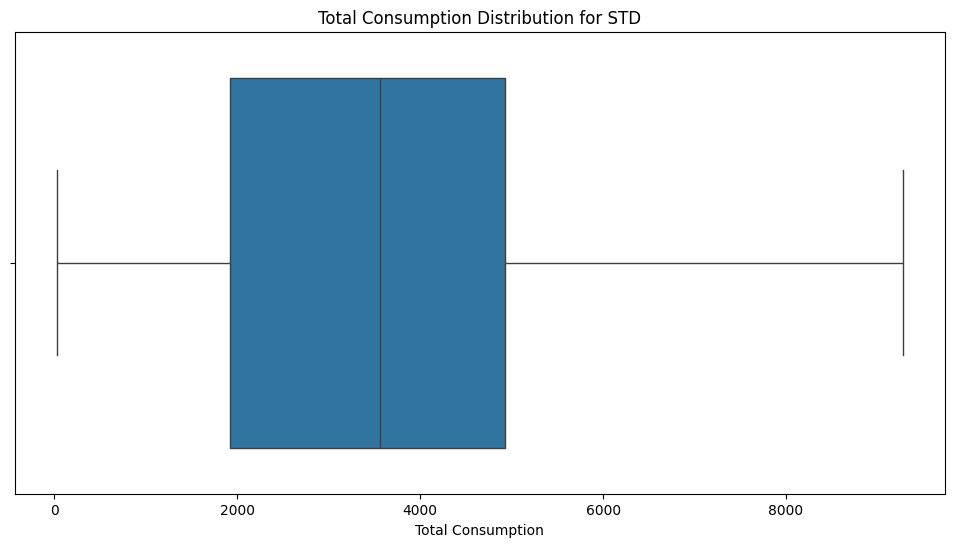

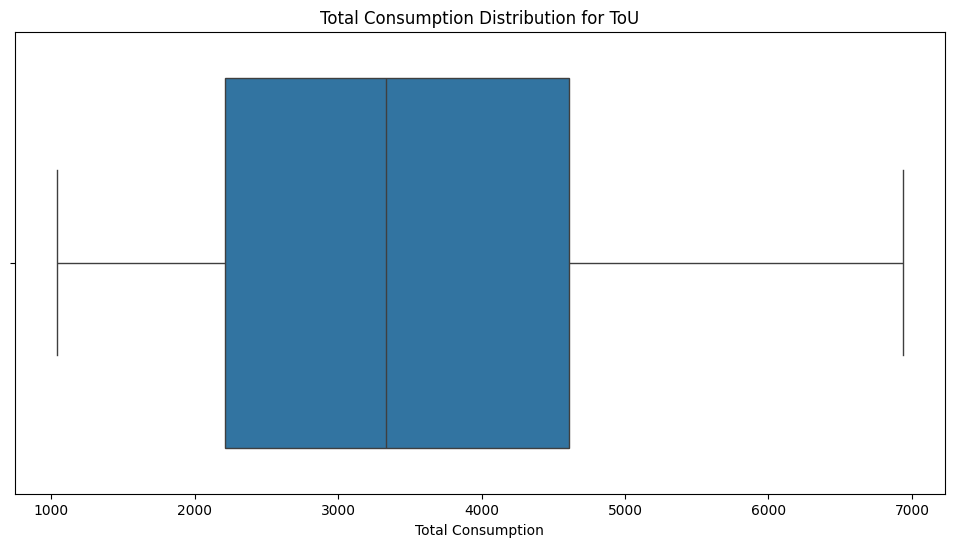

In [50]:
# Identify outliers for STD using the IQR method
std_outliers = identify_outliers_iqr(std_total)

# Identify outliers for ToU using the IQR method
tou_outliers = identify_outliers_iqr(tou_total)

# Plot the example distribution with a custom title
std_outlier_lclid = plot_total_consumption_distribution(std_total, std_outliers, 'Total Consumption Distribution for STD')

# Plot the example distribution with a custom title
tou_outlier_lclid = plot_total_consumption_distribution(tou_total, tou_outliers, 'Total Consumption Distribution for ToU')


# **EDA**

In [51]:
std_data_clean = std_data_imputed.copy()

In [52]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')

In [53]:
tou_data_clean = tou_data_imputed.copy()

## **Plotting a Total Monthly Consumption Graph for both STD & ToU**

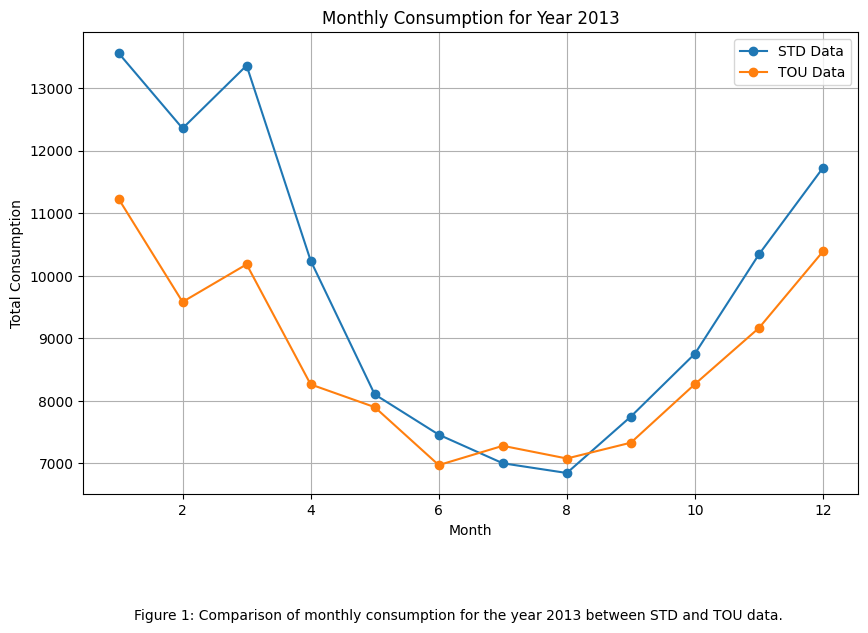

In [54]:
# Calling the function
plot_monthly_consumption(std_data_clean, tou_data_clean)

## Observation: From this line plot it is evident that the Consumers under ToU are having less consumption compared to STD Consumers

In [55]:
# Drop columns 'Hour' and 'Month'
std_data_clean = std_data_clean.drop(columns=['Hour', 'Month'])
tou_data_clean = tou_data_clean.drop(columns=['Hour', 'Month'])

In [56]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [57]:
tou_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [58]:
std_data_clean

,LCLid,DateTime,Consumption
0,MAC000002,2013-01-01 00:00:00,0.219
1,MAC000002,2013-01-01 00:30:00,0.241
2,MAC000002,2013-01-01 01:00:00,0.191
3,MAC000002,2013-01-01 01:30:00,0.235
4,MAC000002,2013-01-01 02:00:00,0.182
...,...,...,...
524545,MAC000039,2013-12-30 22:00:00,0.142
524546,MAC000039,2013-12-30 22:30:00,0.150
524547,MAC000039,2013-12-30 23:00:00,0.202
524548,MAC000039,2013-12-30 23:30:00,0.139


## **Keeping a Copy for Peak analysis of STD**

In [59]:
# Convert DateTime column to datetime objects
for_std_peak_df = std_data_clean.copy()
for_std_peak_df

,LCLid,DateTime,Consumption
0,MAC000002,2013-01-01 00:00:00,0.219
1,MAC000002,2013-01-01 00:30:00,0.241
2,MAC000002,2013-01-01 01:00:00,0.191
3,MAC000002,2013-01-01 01:30:00,0.235
4,MAC000002,2013-01-01 02:00:00,0.182
...,...,...,...
524545,MAC000039,2013-12-30 22:00:00,0.142
524546,MAC000039,2013-12-30 22:30:00,0.150
524547,MAC000039,2013-12-30 23:00:00,0.202
524548,MAC000039,2013-12-30 23:30:00,0.139


In [60]:
for_std_peak_df['DateTime'] = pd.to_datetime(for_std_peak_df['DateTime'])
# Extract the half-hour within the week
for_std_peak_df['HalfHour'] = for_std_peak_df['DateTime'].dt.dayofweek * 48 + for_std_peak_df['DateTime'].dt.hour * 2 + for_std_peak_df['DateTime'].dt.minute//30

# Calculate the average for each half-hour period across all weeks
std_peak_hh_avg = for_std_peak_df.groupby(['LCLid', 'HalfHour']).mean().reset_index()

#Pivot the Data frame
std_peak_hh_avg_pivot = std_peak_hh_avg.pivot(index='LCLid', columns='HalfHour', values='Consumption')
std_peak_hh_avg_pivot.columns.name = None
std_peak_hh_avg_pivot.reset_index(inplace=True)

In [61]:
std_peak_hh_avg_pivot

,LCLid,0,1,2,3,4,5,6,7,8,...,326,327,328,329,330,331,332,333,334,335
0,MAC000002,0.300389,0.262135,0.233865,0.185577,0.158827,0.125442,0.120462,0.113481,0.116135,...,0.530385,0.491750,0.523519,0.373904,0.350000,0.341712,0.351173,0.322365,0.303250,0.320981
1,MAC000003,1.840981,1.815962,1.392058,0.785308,0.894577,0.780038,0.732865,0.864135,0.737346,...,0.207365,0.232865,0.202442,0.176058,0.168000,0.122981,0.118192,0.115788,0.103692,0.093731
2,MAC000004,0.045111,0.025865,0.039019,0.025154,0.040615,0.046173,0.030481,0.038673,0.028885,...,0.024750,0.038596,0.046962,0.035365,0.038192,0.035577,0.038673,0.022500,0.047442,0.032096
3,MAC000006,0.031370,0.031154,0.030212,0.026096,0.032346,0.030462,0.025596,0.032538,0.025231,...,0.088115,0.094058,0.083808,0.088846,0.080712,0.071808,0.066308,0.054192,0.045212,0.039481
4,MAC000007,0.088630,0.069808,0.066077,0.069385,0.074788,0.077442,0.073654,0.073500,0.066750,...,0.469731,0.292346,0.260442,0.302692,0.281865,0.319000,0.248308,0.249019,0.175423,0.127865
5,MAC000009,0.072630,0.062904,0.073519,0.066750,0.064173,0.076865,0.068769,0.069731,0.077885,...,0.305003,0.375349,0.337849,0.273792,0.222437,0.256712,0.178577,0.204481,0.107654,0.105558
6,MAC000010,0.328167,0.267346,0.224154,0.219327,0.212442,0.209712,0.185135,0.180462,0.186692,...,0.970731,0.811000,0.735712,0.714692,0.675962,0.638577,0.640808,0.624000,0.519673,0.428981
7,MAC000011,0.201296,0.180962,0.162423,0.150731,0.146385,0.139250,0.130462,0.126904,0.137538,...,0.461404,0.452577,0.490538,0.454635,0.456654,0.397115,0.431596,0.346712,0.316904,0.245827
8,MAC000012,0.026722,0.027558,0.032462,0.032962,0.029904,0.022769,0.021673,0.023904,0.027942,...,0.057038,0.065462,0.057846,0.042846,0.039058,0.044596,0.049885,0.062365,0.052154,0.040981
9,MAC000013,0.088648,0.079923,0.083558,0.072385,0.072346,0.064558,0.071269,0.065846,0.057827,...,0.149385,0.145981,0.153788,0.157096,0.155846,0.141019,0.120731,0.102654,0.091827,0.098154


## **Normalization**

In [62]:
normalized_std_df, std_scalers = normalize_time_series_data(std_data_clean)
normalized_tou_df, tou_scalers = normalize_time_series_data(tou_data_clean)

In [63]:
copy_norm_std =normalized_std_df.copy()
copy_norm_tou = normalized_tou_df.copy()

##**Weekly Average data for Clustering**

In [64]:
# Convert DateTime column to datetime objects
copy_norm_std['DateTime'] = pd.to_datetime(copy_norm_std['DateTime'])
copy_norm_tou['DateTime'] = pd.to_datetime(copy_norm_tou['DateTime'])

# Extract the half-hour within the week
copy_norm_std['HalfHour'] = copy_norm_std['DateTime'].dt.dayofweek * 48 + copy_norm_std['DateTime'].dt.hour * 2 + copy_norm_std['DateTime'].dt.minute // 30
copy_norm_tou['HalfHour'] = copy_norm_tou['DateTime'].dt.dayofweek * 48 + copy_norm_tou['DateTime'].dt.hour * 2 + copy_norm_tou['DateTime'].dt.minute // 30

# Calculate the average for each half-hour period across all weeks
std_weekly_hh_avg = copy_norm_std.groupby(['LCLid', 'HalfHour']).mean().reset_index()
tou_weekly_hh_avg = copy_norm_tou.groupby(['LCLid', 'HalfHour']).mean().reset_index()
# Drop the DateTime column
std_weekly_hh_avg.drop(columns=['DateTime'], inplace=True)
tou_weekly_hh_avg.drop(columns=['DateTime'], inplace=True)

In [65]:
std_weekly_hh_avg

,LCLid,HalfHour,Consumption
0,MAC000002,0,0.080365
1,MAC000002,1,0.067304
2,MAC000002,2,0.057653
3,MAC000002,3,0.041167
4,MAC000002,4,0.032034
...,...,...,...
10075,MAC000039,331,0.132485
10076,MAC000039,332,0.120914
10077,MAC000039,333,0.093636
10078,MAC000039,334,0.061602


In [66]:
# Pivoting STD Weekly dataframe
std_hh_avg_pivoted_df = std_weekly_hh_avg.pivot(index='LCLid', columns='HalfHour', values='Consumption')
std_hh_avg_pivoted_df.columns.name = None
std_hh_avg_pivoted_df.reset_index(inplace=True)

#Pivoting ToU Weekly average dataframe
tou_hh_avg_pivoted_df = tou_weekly_hh_avg.pivot(index='LCLid', columns='HalfHour', values='Consumption')
tou_hh_avg_pivoted_df.columns.name = None
tou_hh_avg_pivoted_df.reset_index(inplace=True)

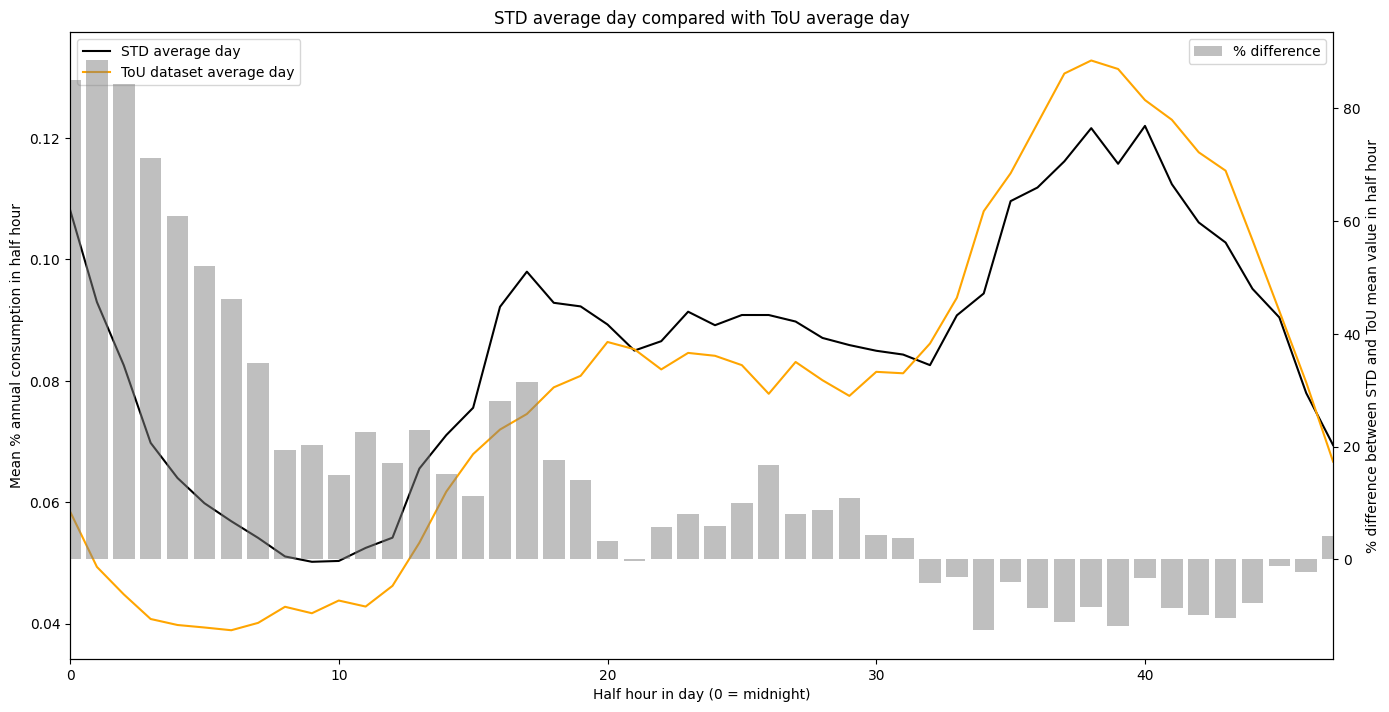

In [67]:
plot_average_day_comparison(std_hh_avg_pivoted_df, tou_hh_avg_pivoted_df)

## **Performing Kmeans Cluster with DTW for STD**

In [68]:
#Perform the PCA
std_pca= perform_pca(std_hh_avg_pivoted_df)

Explained Variance by each component: [4.55431705e-01 3.26904656e-01 4.22942420e-02 2.98985869e-02
 2.40252552e-02 1.74491392e-02 1.55098991e-02 1.41049007e-02
 1.18472904e-02 9.05420086e-03 7.77547236e-03 6.69558636e-03
 6.07525151e-03 5.67745246e-03 4.39784127e-03 3.44473492e-03
 3.21403441e-03 2.96781699e-03 2.46151669e-03 2.06358336e-03
 1.74236248e-03 1.51601935e-03 1.44348399e-03 1.07128193e-03
 1.00673672e-03 6.45159349e-04 5.93519937e-04 4.06810520e-04
 2.81460367e-04 8.98180667e-32]
Cumulative Explained Variance: [0.4554317  0.78233636 0.8246306  0.85452919 0.87855444 0.89600358
 0.91151348 0.92561838 0.93746567 0.94651988 0.95429535 0.96099093
 0.96706619 0.97274364 0.97714148 0.98058621 0.98380025 0.98676807
 0.98922958 0.99129317 0.99303553 0.99455155 0.99599503 0.99706631
 0.99807305 0.99871821 0.99931173 0.99971854 1.         1.        ]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.867 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.710 --> 0.684 --> 0.684 --> 
0.475 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.368 --> 0.360 --> 0.360 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.373 --> 0.285 --> 0.285 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.311 --> 0.242 --> 0.234 --> 0.228 --> 0.228 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.282 --> 0.221 --> 0.221 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

0.248 --> 0.189 --> 0.189 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.242 --> 0.170 --> 0.170 --> 


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

0.211 --> 0.141 --> 0.141 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

0.182 --> 0.123 --> 0.123 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


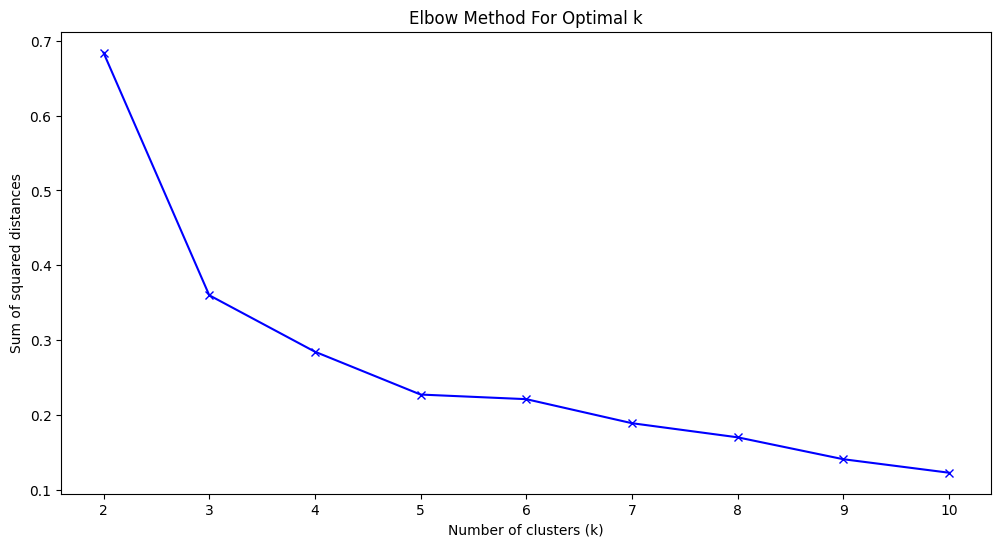

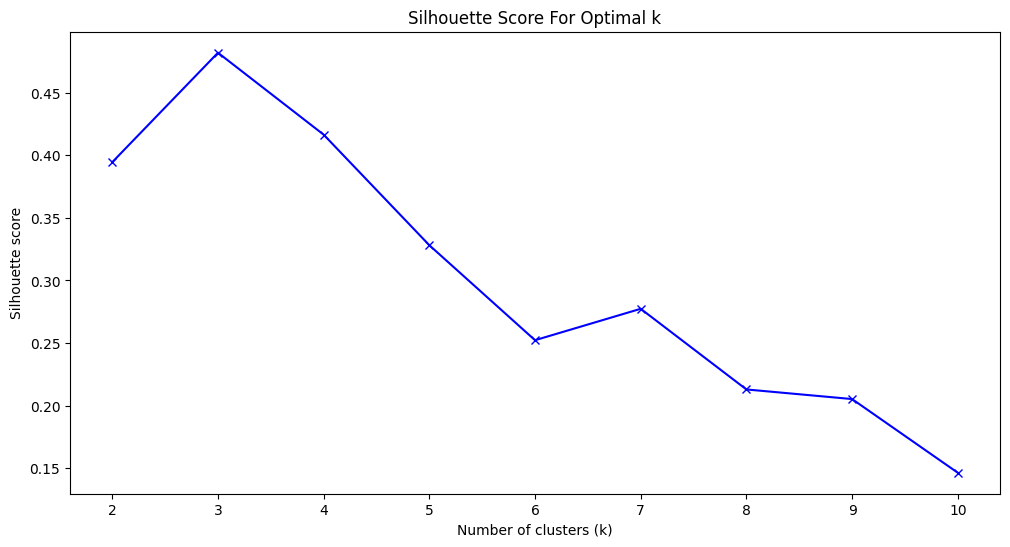

Optimal number of clusters: 3


In [69]:
# Find the Optimal number of Cluster
find_optimal_clusters_pca(std_pca, max_clusters=10)

In [70]:
# Perform Clustering with the optimal number of clusters
std_pca_with_clusters = perform_clustering(std_pca, n_clusters=3)

0.475 --> 0.368 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.360 --> 0.360 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


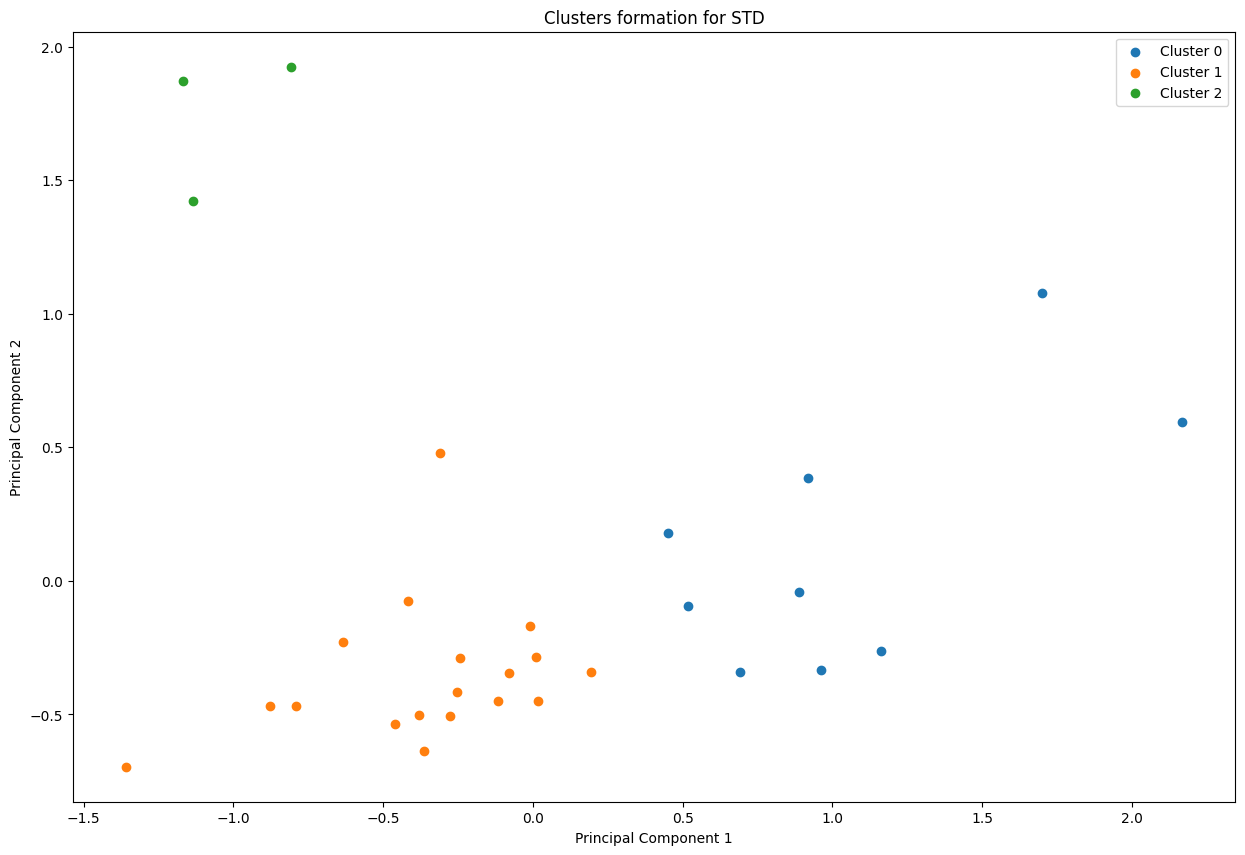

In [71]:
# Plot clusters using the first two PCA components
plot_clusters(std_pca_with_clusters, 'Clusters formation for STD')

In [72]:
std_hh_avg_pivoted_df['Cluster'] = std_pca_with_clusters['Cluster']

In [73]:
std_peak_hh_avg_pivot['Cluster']= std_pca_with_clusters['Cluster']
std_peak_hh_avg_pivot

,LCLid,0,1,2,3,4,5,6,7,8,...,327,328,329,330,331,332,333,334,335,Cluster
0,MAC000002,0.300389,0.262135,0.233865,0.185577,0.158827,0.125442,0.120462,0.113481,0.116135,...,0.491750,0.523519,0.373904,0.350000,0.341712,0.351173,0.322365,0.303250,0.320981,1
1,MAC000003,1.840981,1.815962,1.392058,0.785308,0.894577,0.780038,0.732865,0.864135,0.737346,...,0.232865,0.202442,0.176058,0.168000,0.122981,0.118192,0.115788,0.103692,0.093731,2
2,MAC000004,0.045111,0.025865,0.039019,0.025154,0.040615,0.046173,0.030481,0.038673,0.028885,...,0.038596,0.046962,0.035365,0.038192,0.035577,0.038673,0.022500,0.047442,0.032096,1
3,MAC000006,0.031370,0.031154,0.030212,0.026096,0.032346,0.030462,0.025596,0.032538,0.025231,...,0.094058,0.083808,0.088846,0.080712,0.071808,0.066308,0.054192,0.045212,0.039481,1
4,MAC000007,0.088630,0.069808,0.066077,0.069385,0.074788,0.077442,0.073654,0.073500,0.066750,...,0.292346,0.260442,0.302692,0.281865,0.319000,0.248308,0.249019,0.175423,0.127865,1
5,MAC000009,0.072630,0.062904,0.073519,0.066750,0.064173,0.076865,0.068769,0.069731,0.077885,...,0.375349,0.337849,0.273792,0.222437,0.256712,0.178577,0.204481,0.107654,0.105558,1
6,MAC000010,0.328167,0.267346,0.224154,0.219327,0.212442,0.209712,0.185135,0.180462,0.186692,...,0.811000,0.735712,0.714692,0.675962,0.638577,0.640808,0.624000,0.519673,0.428981,0
7,MAC000011,0.201296,0.180962,0.162423,0.150731,0.146385,0.139250,0.130462,0.126904,0.137538,...,0.452577,0.490538,0.454635,0.456654,0.397115,0.431596,0.346712,0.316904,0.245827,0
8,MAC000012,0.026722,0.027558,0.032462,0.032962,0.029904,0.022769,0.021673,0.023904,0.027942,...,0.065462,0.057846,0.042846,0.039058,0.044596,0.049885,0.062365,0.052154,0.040981,1
9,MAC000013,0.088648,0.079923,0.083558,0.072385,0.072346,0.064558,0.071269,0.065846,0.057827,...,0.145981,0.153788,0.157096,0.155846,0.141019,0.120731,0.102654,0.091827,0.098154,0


In [74]:
base_peak_loads = calculate_daily_base_peak_with_timesteps(std_peak_hh_avg_pivot.copy())

In [75]:
base_peak_loads

,Day 1 Base Value,Day 1 Base Timestep,Day 1 Peak Value,Day 1 Peak Timestep,Day 2 Base Value,Day 2 Base Timestep,Day 2 Peak Value,Day 2 Peak Timestep,Day 3 Base Value,Day 3 Base Timestep,...,Day 5 Peak Timestep,Day 6 Base Value,Day 6 Base Timestep,Day 6 Peak Value,Day 6 Peak Timestep,Day 7 Base Value,Day 7 Base Timestep,Day 7 Peak Value,Day 7 Peak Timestep,Cluster
0,0.065670,10,0.412063,38,0.070334,58,0.345296,88,0.067794,104,...,232,0.071061,252,0.341101,278,0.066604,297,0.479161,326,1
1,0.073250,29,1.996877,0,0.070346,78,2.015963,48,0.069385,95,...,192,0.065417,239,2.018895,241,0.067186,287,1.983886,289,2
2,0.148581,9,0.543365,36,0.148419,56,0.544224,85,0.147071,104,...,228,0.147648,247,0.482237,277,0.151504,295,0.534282,324,0


In [76]:
base_peak_df = base_peak_loads.rename(columns={'index': 'Cluster'})

In [77]:
base_peak_df

,Day 1 Base Value,Day 1 Base Timestep,Day 1 Peak Value,Day 1 Peak Timestep,Day 2 Base Value,Day 2 Base Timestep,Day 2 Peak Value,Day 2 Peak Timestep,Day 3 Base Value,Day 3 Base Timestep,...,Day 5 Peak Timestep,Day 6 Base Value,Day 6 Base Timestep,Day 6 Peak Value,Day 6 Peak Timestep,Day 7 Base Value,Day 7 Base Timestep,Day 7 Peak Value,Day 7 Peak Timestep,Cluster
0,0.065670,10,0.412063,38,0.070334,58,0.345296,88,0.067794,104,...,232,0.071061,252,0.341101,278,0.066604,297,0.479161,326,1
1,0.073250,29,1.996877,0,0.070346,78,2.015963,48,0.069385,95,...,192,0.065417,239,2.018895,241,0.067186,287,1.983886,289,2
2,0.148581,9,0.543365,36,0.148419,56,0.544224,85,0.147071,104,...,228,0.147648,247,0.482237,277,0.151504,295,0.534282,324,0


In [78]:
base_peak_df.to_csv('base_peak_loads.csv', index=False)

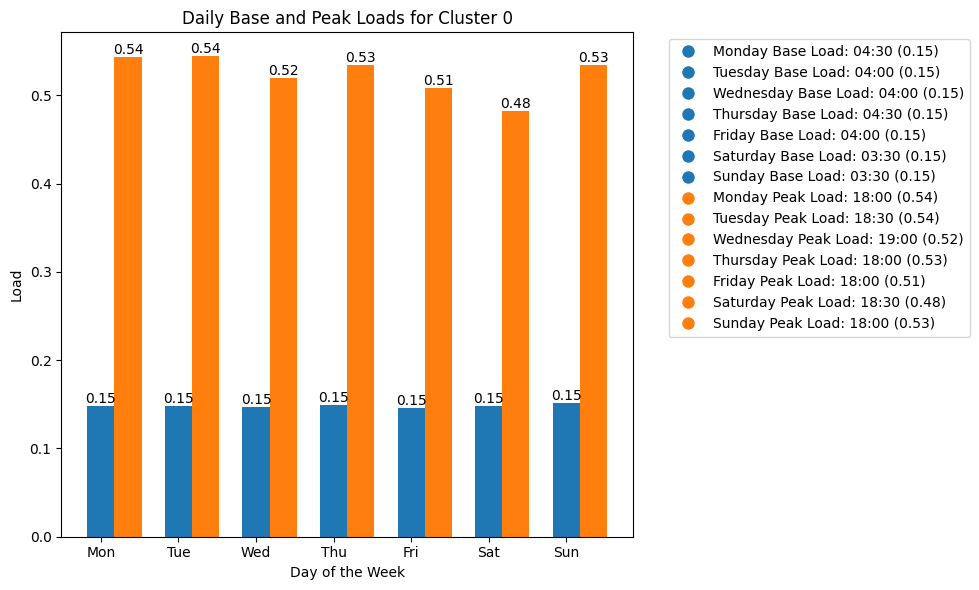

In [79]:
plot_daily_base_peak(base_peak_df, cluster_id=0)

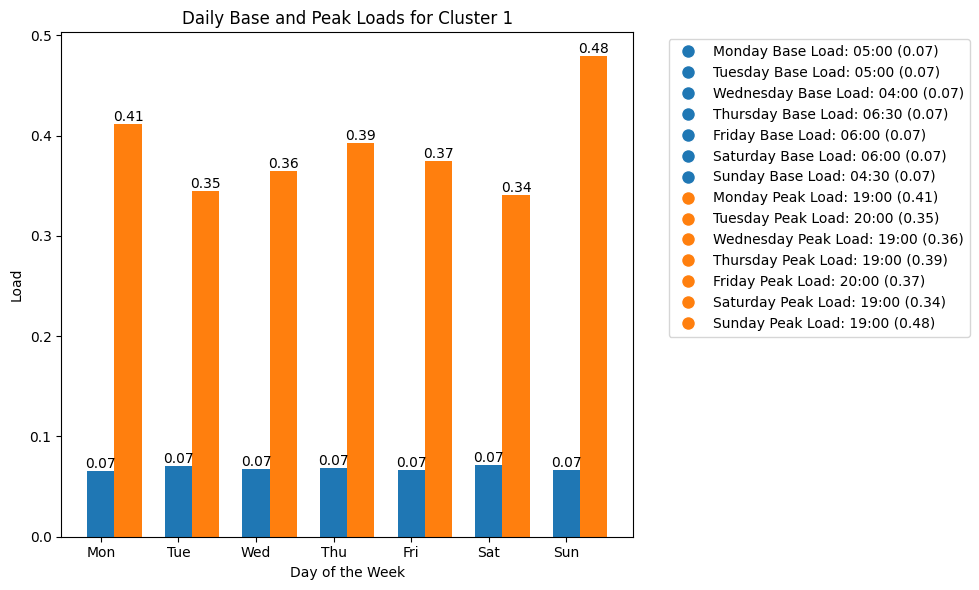

In [80]:
plot_daily_base_peak(base_peak_df, cluster_id=1)

In [ ]:
plot_daily_base_peak(base_peak_df, cluster_id=2)

In [82]:
std_peak_hh_avg_pivot

,LCLid,0,1,2,3,4,5,6,7,8,...,327,328,329,330,331,332,333,334,335,Cluster
0,MAC000002,0.300389,0.262135,0.233865,0.185577,0.158827,0.125442,0.120462,0.113481,0.116135,...,0.491750,0.523519,0.373904,0.350000,0.341712,0.351173,0.322365,0.303250,0.320981,1
1,MAC000003,1.840981,1.815962,1.392058,0.785308,0.894577,0.780038,0.732865,0.864135,0.737346,...,0.232865,0.202442,0.176058,0.168000,0.122981,0.118192,0.115788,0.103692,0.093731,2
2,MAC000004,0.045111,0.025865,0.039019,0.025154,0.040615,0.046173,0.030481,0.038673,0.028885,...,0.038596,0.046962,0.035365,0.038192,0.035577,0.038673,0.022500,0.047442,0.032096,1
3,MAC000006,0.031370,0.031154,0.030212,0.026096,0.032346,0.030462,0.025596,0.032538,0.025231,...,0.094058,0.083808,0.088846,0.080712,0.071808,0.066308,0.054192,0.045212,0.039481,1
4,MAC000007,0.088630,0.069808,0.066077,0.069385,0.074788,0.077442,0.073654,0.073500,0.066750,...,0.292346,0.260442,0.302692,0.281865,0.319000,0.248308,0.249019,0.175423,0.127865,1
5,MAC000009,0.072630,0.062904,0.073519,0.066750,0.064173,0.076865,0.068769,0.069731,0.077885,...,0.375349,0.337849,0.273792,0.222437,0.256712,0.178577,0.204481,0.107654,0.105558,1
6,MAC000010,0.328167,0.267346,0.224154,0.219327,0.212442,0.209712,0.185135,0.180462,0.186692,...,0.811000,0.735712,0.714692,0.675962,0.638577,0.640808,0.624000,0.519673,0.428981,0
7,MAC000011,0.201296,0.180962,0.162423,0.150731,0.146385,0.139250,0.130462,0.126904,0.137538,...,0.452577,0.490538,0.454635,0.456654,0.397115,0.431596,0.346712,0.316904,0.245827,0
8,MAC000012,0.026722,0.027558,0.032462,0.032962,0.029904,0.022769,0.021673,0.023904,0.027942,...,0.065462,0.057846,0.042846,0.039058,0.044596,0.049885,0.062365,0.052154,0.040981,1
9,MAC000013,0.088648,0.079923,0.083558,0.072385,0.072346,0.064558,0.071269,0.065846,0.057827,...,0.145981,0.153788,0.157096,0.155846,0.141019,0.120731,0.102654,0.091827,0.098154,0


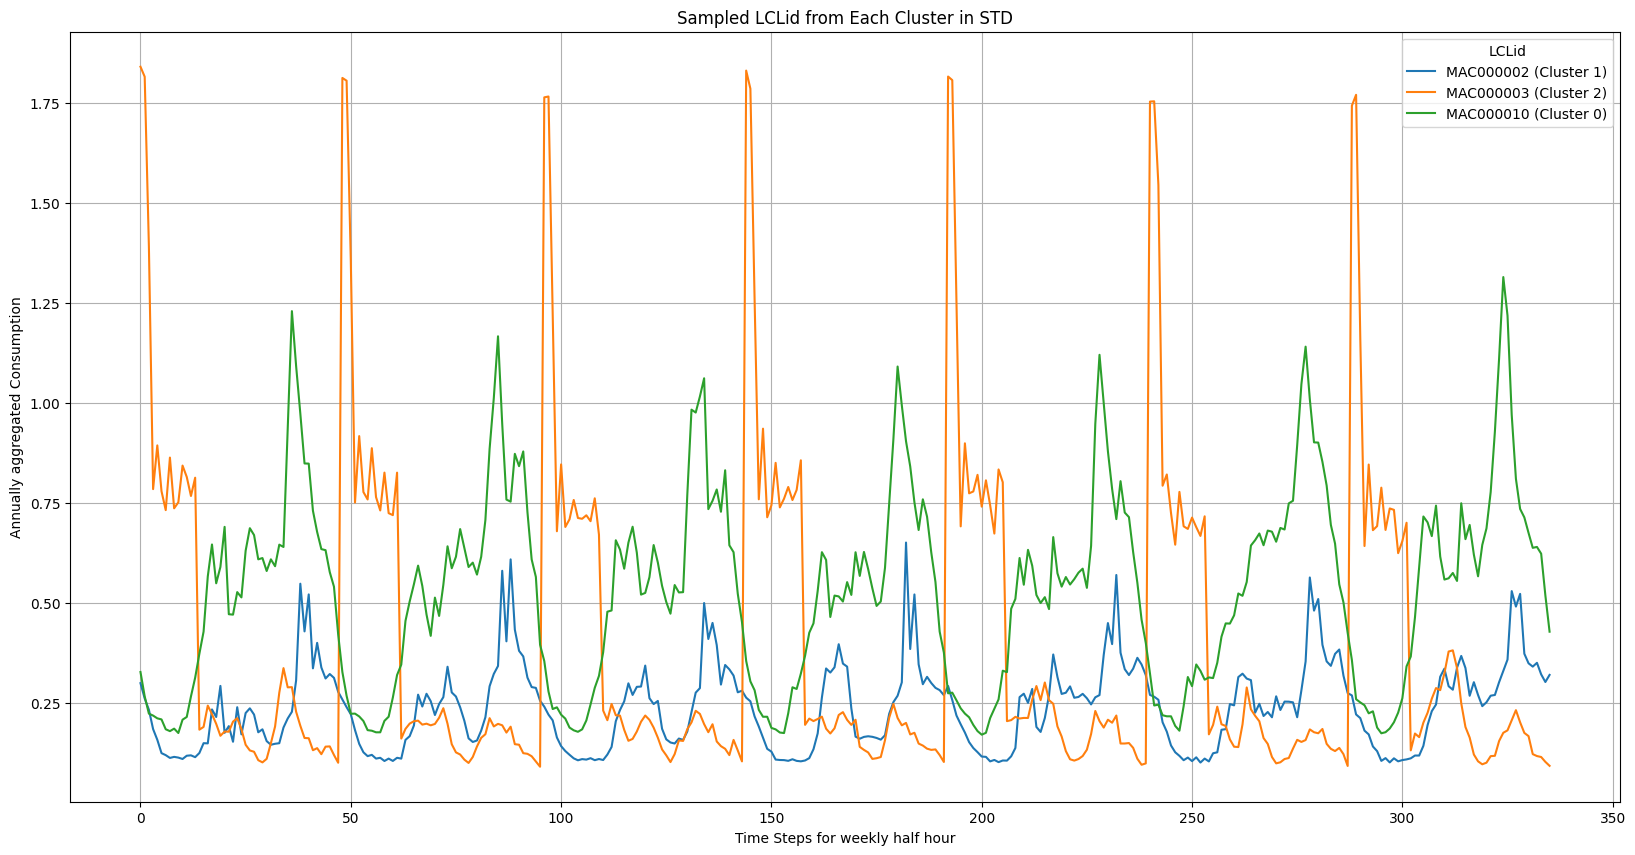

In [83]:
# Pick 1 LCLid from each cluster
clusters = std_peak_hh_avg_pivot['Cluster'].unique()
sampled_df = pd.concat([std_peak_hh_avg_pivot[std_peak_hh_avg_pivot['Cluster'] == cluster].head(1) for cluster in clusters])

# Plotting the sampled LCLid
plt.figure(figsize=(20, 10))

# Plotting only numeric columns
numeric_columns = std_peak_hh_avg_pivot.columns[1:-1]

for index, row in sampled_df.iterrows():
    plt.plot(numeric_columns, row[numeric_columns], label=f"{row['LCLid']} (Cluster {row['Cluster']})")

plt.xlabel('Time Steps for weekly half hour')
plt.ylabel('Annually aggregated Consumption')
plt.title('Sampled LCLid from Each Cluster in STD')
plt.legend(title='LCLid')
plt.grid(True)
plt.show()

**We will be taking these LCLid from each clusters for forecasting models**

## **Forecasting**

### **Loading Weather Data**

In [84]:
weather_data = pd.read_csv('/content/drive/MyDrive/open-meteo-51.49N0.16W23m (1).csv', skiprows=3)

In [85]:
weather_data.head()

,time,temperature_2m (°C)
0,2010-01-01T00:00,0.4
1,2010-01-01T01:00,0.3
2,2010-01-01T02:00,0.1
3,2010-01-01T03:00,-0.2
4,2010-01-01T04:00,-0.4


In [86]:
# Convert 'time' column to datetime objects, coerce errors to handle inconsistencies
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

# Drop rows with NaT in 'time' column (result of conversion errors)
weather_data = weather_data.dropna(subset=['time'])

# Filter the DataFrame for the specified date range
start_date = "2013-01-01"
end_date = "2013-12-31"

# Ensure that start_date and end_date are datetime objects and include the time component
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # End of day

mask = (weather_data['time'] >= start_date) & (weather_data['time'] <= end_date)
filtered_weather_data = weather_data.loc[mask].copy()

# Reset the index of the filtered DataFrame
filtered_weather_data.reset_index(drop=True, inplace=True)

# Format the 'time' column to the desired format without the "T"
filtered_weather_data['time'] = filtered_weather_data['time'].dt.strftime("%Y-%m-%d %H:%M")

# Display the filtered and formatted DataFrame
print(filtered_weather_data.head())

               time temperature_2m (°C)
0  2013-01-01 00:00                 8.6
1  2013-01-01 01:00                 8.3
2  2013-01-01 02:00                 7.5
3  2013-01-01 03:00                 6.8
4  2013-01-01 04:00                 5.9


In [87]:
#Renaiming the columns to align with std cluster data
filtered_weather_data.rename(columns={'time': 'DateTime', 'temperature_2m (°C)': 'Temp'}, inplace=True)


In [88]:
filtered_weather_data

,DateTime,Temp
0,2013-01-01 00:00,8.6
1,2013-01-01 01:00,8.3
2,2013-01-01 02:00,7.5
3,2013-01-01 03:00,6.8
4,2013-01-01 04:00,5.9
...,...,...
8755,2013-12-31 19:00,5.8
8756,2013-12-31 20:00,5.7
8757,2013-12-31 21:00,5.6
8758,2013-12-31 22:00,5.9


In [89]:
# Convert the 'Temp' column to numeric type
filtered_weather_data['Temp'] = pd.to_numeric(filtered_weather_data['Temp'], errors='coerce')

# Set 'DateTime' as the index (this MUST be done BEFORE resampling)
filtered_weather_data = filtered_weather_data.set_index('DateTime')
# Ensure 'DateTime' index is of datetime type
filtered_weather_data.index = pd.to_datetime(filtered_weather_data.index)

# Resample and interpolate only the 'Temp' column
filtered_weather_data_hh = filtered_weather_data[['Temp']].resample('30min').interpolate().reset_index()


In [90]:
filtered_weather_data_hh

,DateTime,Temp
0,2013-01-01 00:00:00,8.60
1,2013-01-01 00:30:00,8.45
2,2013-01-01 01:00:00,8.30
3,2013-01-01 01:30:00,7.90
4,2013-01-01 02:00:00,7.50
...,...,...
17514,2013-12-31 21:00:00,5.60
17515,2013-12-31 21:30:00,5.75
17516,2013-12-31 22:00:00,5.90
17517,2013-12-31 22:30:00,6.05


### **Keeping a copy for Sarimax**

In [91]:
sarimax_cluster_01_hh = std_data_clean[std_data_clean['LCLid'] == 'MAC000002'].copy()
sarimax_cluster_02_hh = std_data_clean[std_data_clean['LCLid'] == 'MAC000003'].copy()
sarimax_cluster_00_hh = std_data_clean[std_data_clean['LCLid'] == 'MAC000010'].copy()
temp_for_sarimax = filtered_weather_data_hh.copy()

## **Merging std cluster data & Temperature for Sarimax**

In [92]:
# Convert 'DateTime' columns to datetime
sarimax_cluster_00_hh['DateTime'] = pd.to_datetime(sarimax_cluster_00_hh['DateTime'])
sarimax_cluster_01_hh['DateTime'] = pd.to_datetime(sarimax_cluster_01_hh['DateTime'])
sarimax_cluster_02_hh['DateTime'] = pd.to_datetime(sarimax_cluster_02_hh['DateTime'])
temp_for_sarimax['DateTime'] = pd.to_datetime(temp_for_sarimax['DateTime'])

# Merge the DataFrames on 'DateTime'
sarimax_cluster_00_temp = pd.merge(sarimax_cluster_00_hh, temp_for_sarimax, on='DateTime', how='inner')
sarimax_cluster_01_temp = pd.merge(sarimax_cluster_01_hh, temp_for_sarimax, on='DateTime', how='inner')
sarimax_cluster_02_temp = pd.merge(sarimax_cluster_02_hh, temp_for_sarimax , on='DateTime', how='inner')

In [93]:
#Dropping LCLid Column
sarimax_cluster_00_temp.drop(columns=['LCLid'], inplace=True)
sarimax_cluster_01_temp.drop(columns=['LCLid'], inplace=True)
sarimax_cluster_02_temp.drop(columns=['LCLid'], inplace=True)



##**SARIMAX Model**

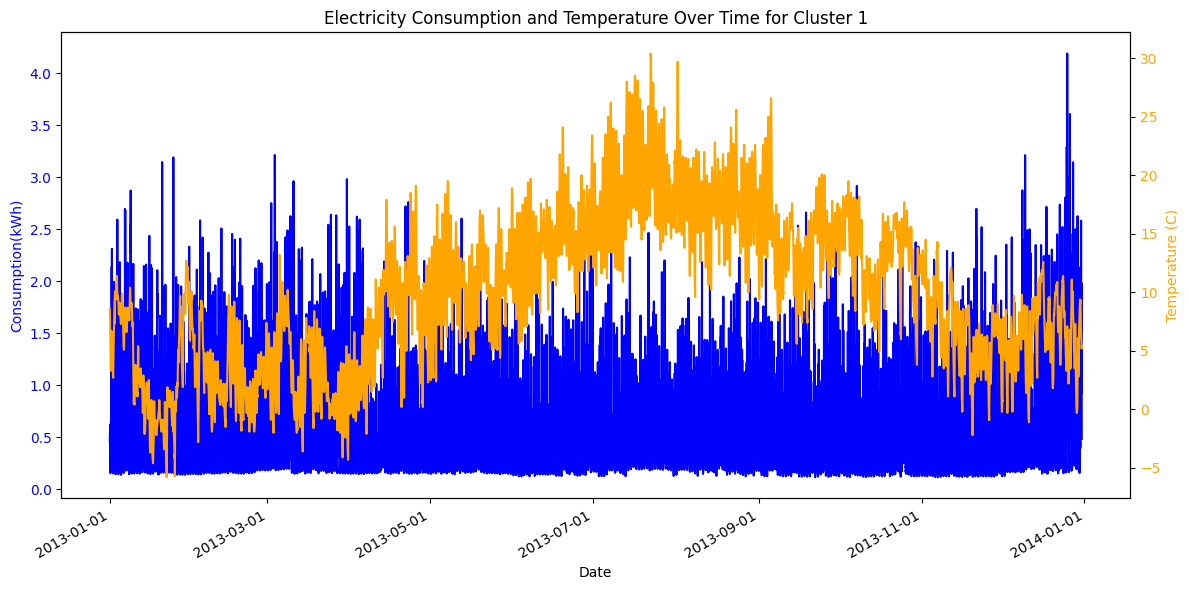

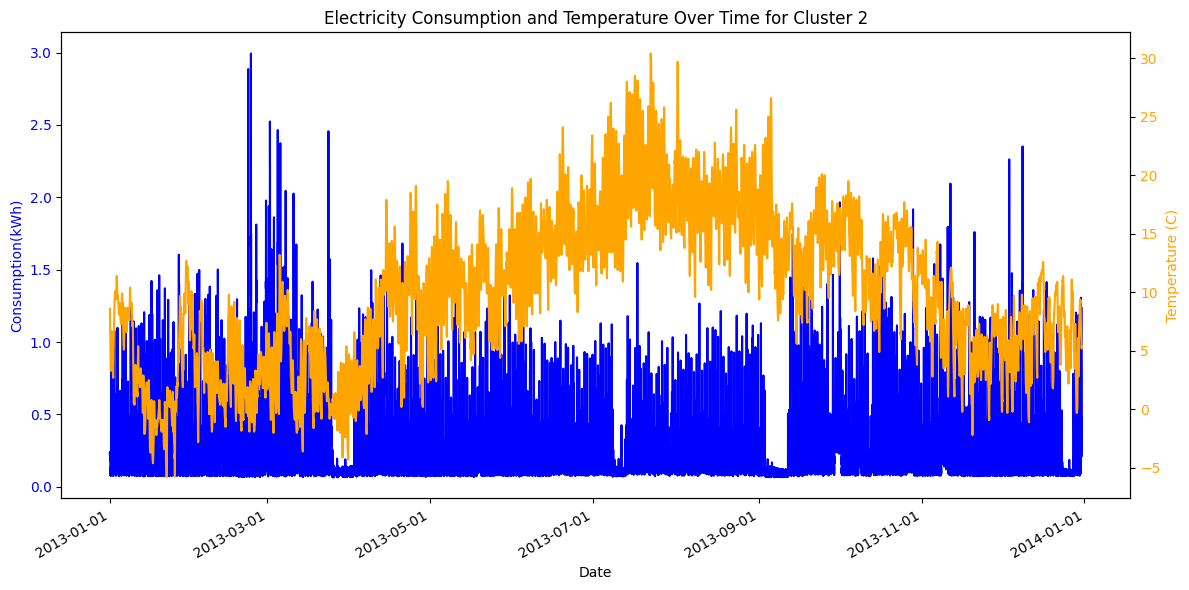

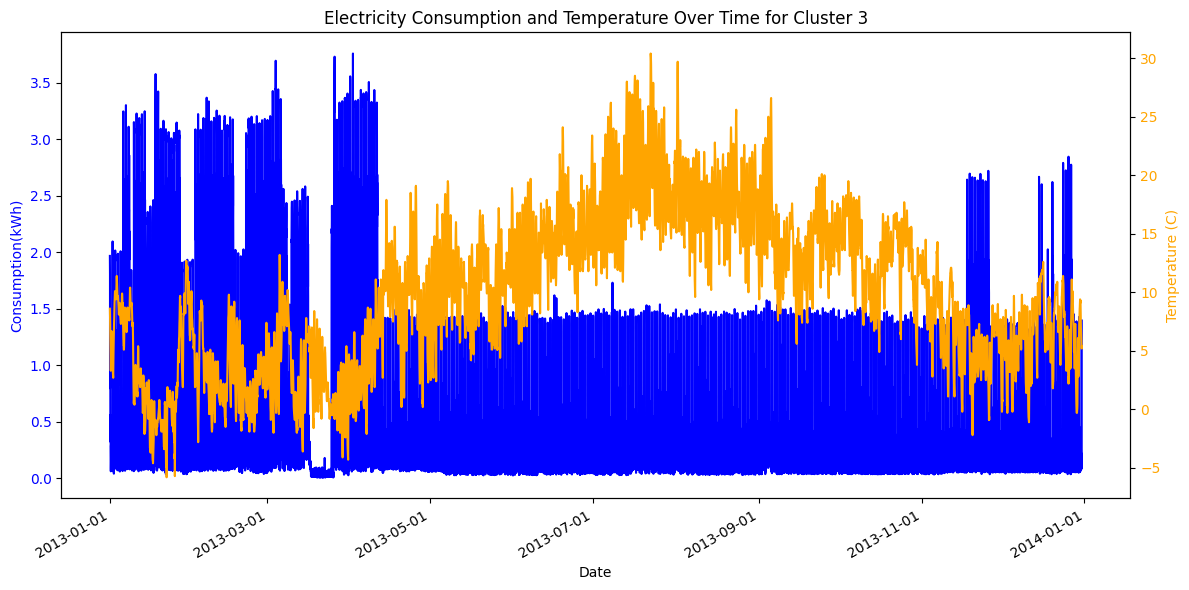

In [94]:
#Plotting the Temperature and Consumption over time for three clusters

# Ensure proper datetime parsing
sarimax_cluster_00_temp['DateTime'] = pd.to_datetime(sarimax_cluster_00_temp['DateTime'])
sarimax_cluster_01_temp['DateTime'] = pd.to_datetime(sarimax_cluster_01_temp['DateTime'])
sarimax_cluster_02_temp['DateTime'] = pd.to_datetime(sarimax_cluster_02_temp['DateTime'])

# Set the DateTime column as the index
sarimax_cluster_00_temp.set_index('DateTime', inplace=True)
sarimax_cluster_01_temp.set_index('DateTime', inplace=True)
sarimax_cluster_02_temp.set_index('DateTime', inplace=True)

dataframes = [sarimax_cluster_00_temp, sarimax_cluster_01_temp, sarimax_cluster_02_temp]
titles = [
    'Electricity Consumption and Temperature Over Time for Cluster 1',
    'Electricity Consumption and Temperature Over Time for Cluster 2',
    'Electricity Consumption and Temperature Over Time for Cluster 3'
]

plot_consumption_temperature(dataframes, titles)

## **Checking for Stationary**

In [ ]:
# List of columns to check for stationarity
columns_to_check = ['Consumption', 'Temp']

# Call the check_stationarity function
check_stationarity(sarimax_cluster_00_temp, columns_to_check)
check_stationarity(sarimax_cluster_01_temp, columns_to_check)
check_stationarity(sarimax_cluster_02_temp, columns_to_check)

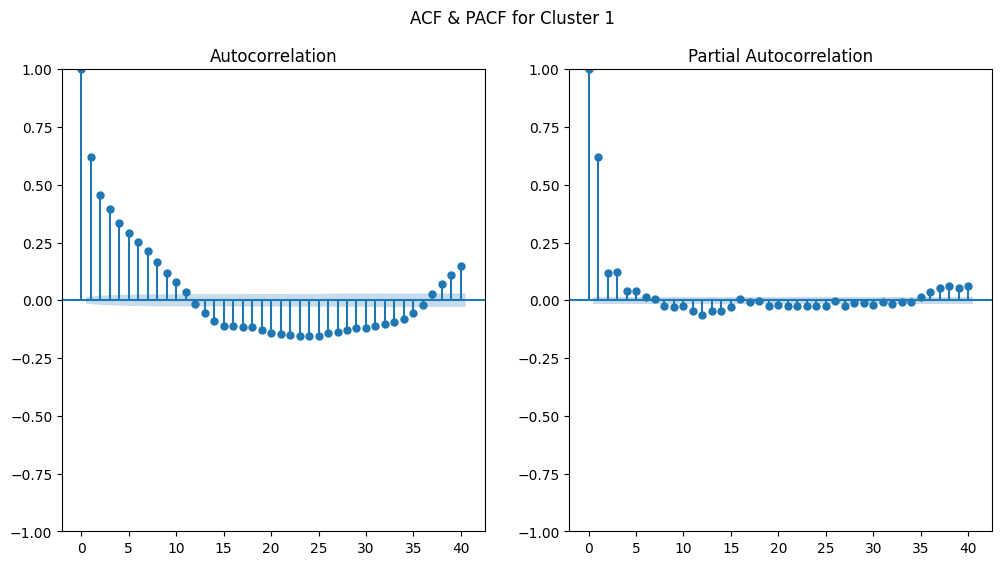

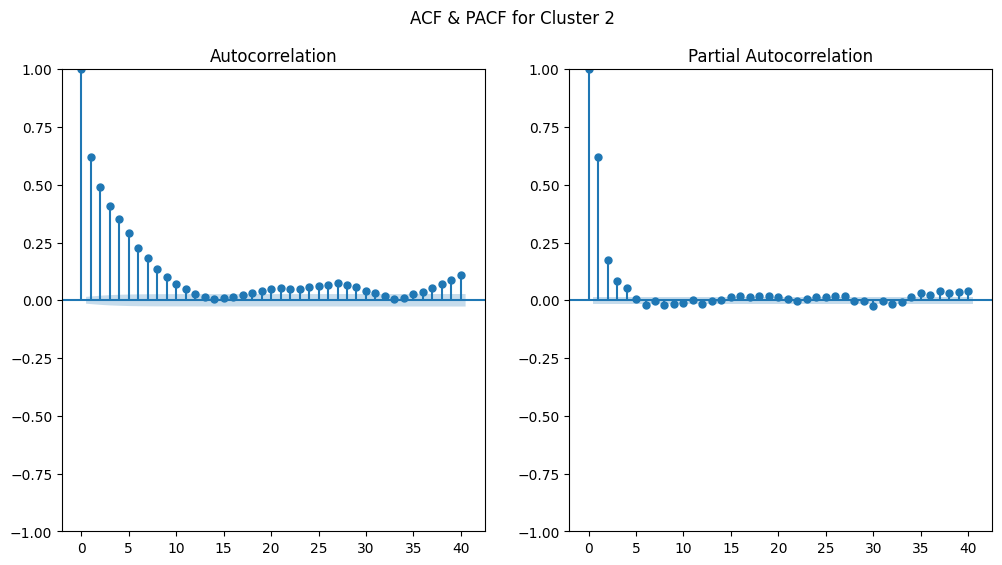

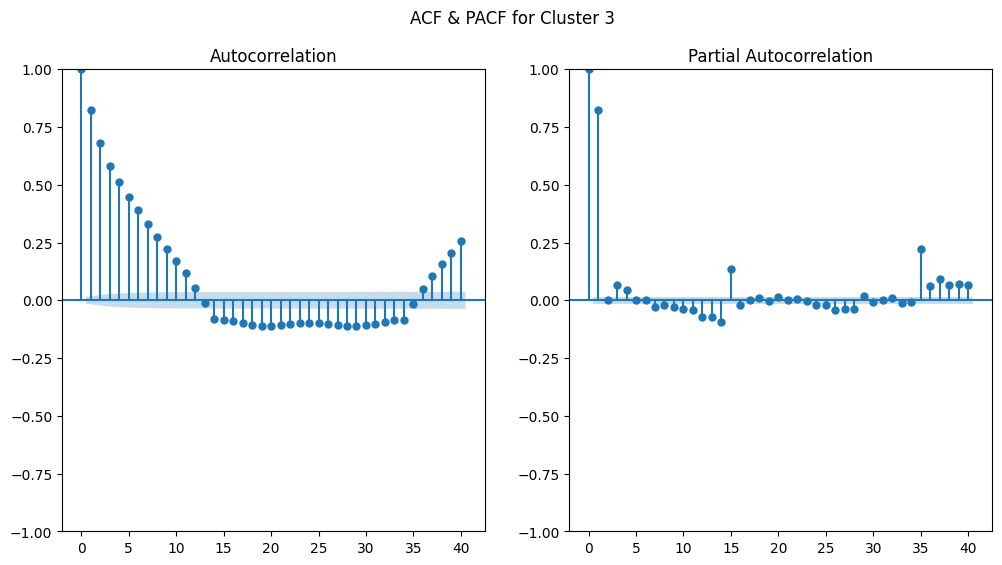

In [96]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data, lags, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.subplot(122)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.suptitle(title)
    plt.show()

# Use this function to manually determine the order and seasonal order
plot_acf_pacf(sarimax_cluster_00_temp['Consumption'], lags=40, title="ACF & PACF for Cluster 1")
plot_acf_pacf(sarimax_cluster_01_temp['Consumption'], lags=40, title="ACF & PACF for Cluster 2")
plot_acf_pacf(sarimax_cluster_02_temp['Consumption'], lags=40, title="ACF & PACF for Cluster 3")

In [102]:
def remove_duplicates(df):
    if df.index.duplicated().any():
        print("Duplicate indices found. Removing duplicates...")
        df = df[~df.index.duplicated(keep='first')]
    return df

# Remove duplicates from each DataFrame
sarimax_cluster_00_temp = remove_duplicates(sarimax_cluster_00_temp)
sarimax_cluster_01_temp = remove_duplicates(sarimax_cluster_01_temp)
sarimax_cluster_02_temp = remove_duplicates(sarimax_cluster_02_temp)


Duplicate indices found. Removing duplicates...
Duplicate indices found. Removing duplicates...
Duplicate indices found. Removing duplicates...


In [103]:
def prepare_data_for_sarimax(merged_data, train_end_date):
    train_end_date = pd.to_datetime(train_end_date)

    # Ensure the DateTime index is sorted
    merged_data = merged_data.sort_index()

    # Split the data
    train_data = merged_data[merged_data.index <= train_end_date]
    test_data = merged_data[merged_data.index > train_end_date]

    # Check for empty data after split
    if train_data.empty or test_data.empty:
        raise ValueError("Training or testing data is empty after the split.")

    # Normalize the data
    scaler_consumption = MinMaxScaler()
    consumption_train_data = scaler_consumption.fit_transform(train_data[['Consumption']])
    consumption_test_data = scaler_consumption.transform(test_data[['Consumption']])

    scaler_temperature = MinMaxScaler()
    temp_train_data = scaler_temperature.fit_transform(train_data[['Temp']])
    temp_test_data = scaler_temperature.transform(test_data[['Temp']])

    # Combine normalized data
    train_data_combined = np.hstack((consumption_train_data, temp_train_data))
    test_data_combined = np.hstack((consumption_test_data, temp_test_data))

    return train_data, test_data, scaler_consumption, scaler_temperature


In [104]:
# Set the correct train end date based on the actual data range
train_end_date = '2013-10-31 23:30:00'

# Prepare data for each cluster using the cleaned DataFrame
train_00, test_00, scaler_consumption_00, scaler_temperature_00 = prepare_data_for_sarimax(
    sarimax_cluster_00_temp, train_end_date
)

train_01, test_01, scaler_consumption_01, scaler_temperature_01 = prepare_data_for_sarimax(
    sarimax_cluster_01_temp, train_end_date
)

train_02, test_02, scaler_consumption_02, scaler_temperature_02 = prepare_data_for_sarimax(
    sarimax_cluster_02_temp, train_end_date
)


In [105]:
def train_evaluate_sarimax(train, test, cluster_name, order, seasonal_order, scaler_consumption, scaler_temperature=None):
    try:
        # Ensure DateTime index has a frequency
        train = train.asfreq('30T')
        test = test.asfreq('30T')

        # Fit SARIMAX model
        model = SARIMAX(train['Consumption'], exog=train[['Temp']], order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False, maxiter=1000)

        # Predict on the test set
        forecast = results.get_forecast(steps=len(test), exog=test[['Temp']])
        predicted_values = forecast.predicted_mean

        # Inverse transform the predictions (scaling)
        original_scale_predictions = scaler_consumption.inverse_transform(predicted_values.values.reshape(-1, 1))

        # Calculate residuals for training and evaluation
        train_loss = train['Consumption'] - results.fittedvalues
        evaluation_loss = test['Consumption'] - original_scale_predictions.flatten()

        # Calculate metrics
        mse = mean_squared_error(test['Consumption'], original_scale_predictions)
        mae = mean_absolute_error(test['Consumption'], original_scale_predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test['Consumption'] - original_scale_predictions.flatten()) / test['Consumption'])) * 100

        print(f'{cluster_name} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

        # Plot training and evaluation loss
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train_loss, label='Training Loss', color='red')
        plt.plot(test.index, evaluation_loss, label='Evaluation Loss', color='blue')
        plt.xlabel('Date')
        plt.ylabel('Residuals (Loss)')
        plt.title(f'Training and Evaluation Loss for {cluster_name}')
        plt.legend()
        plt.show()

        # Plot test and forecasted values
        plt.figure(figsize=(12, 6))
        plt.plot(test.index, test['Consumption'], label='Actual', color='blue', linestyle='--')
        plt.plot(test.index, original_scale_predictions, label='Forecast', color='orange')
        plt.xlabel('Date')
        plt.ylabel('Consumption')
        plt.title(f'SARIMAX Model: Test vs Forecast for {cluster_name}')
        plt.legend()
        plt.show()

        return results, original_scale_predictions

    except Exception as e:
        print(f"An error occurred for {cluster_name}: {e}")


Cluster 00 - MSE: 2.1596204756418587, MAE: 1.3462336361799614, RMSE: 1.469564723189101, MAPE: 356.2818003371233


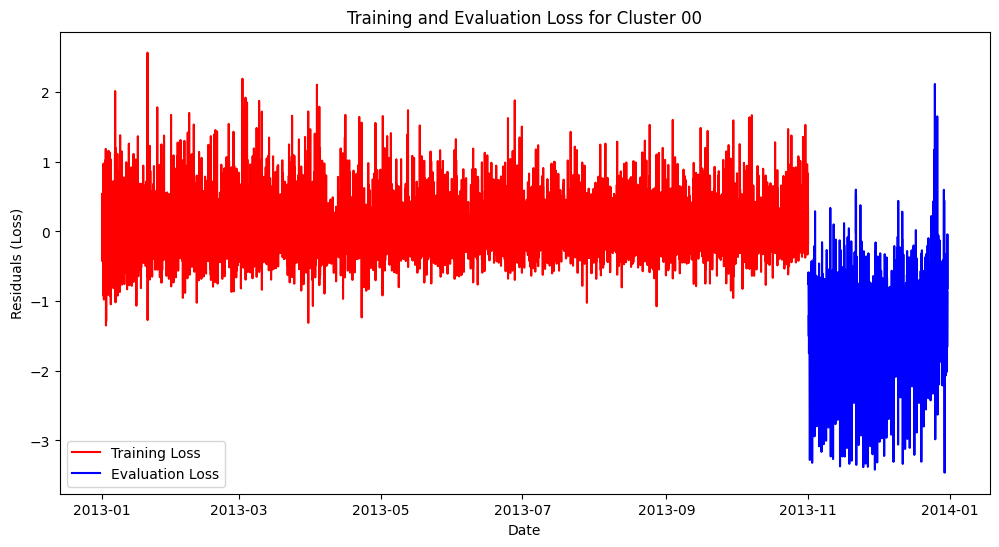

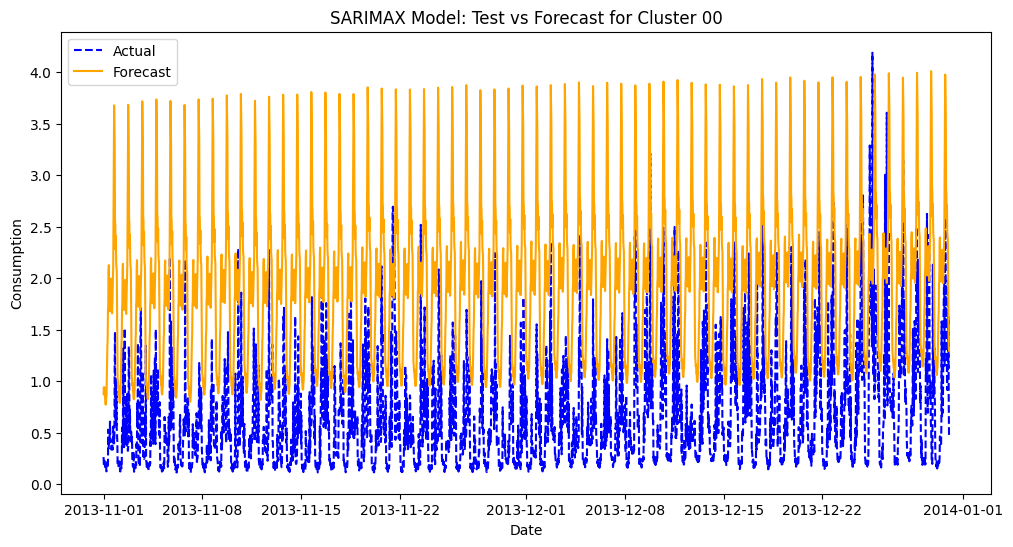

Cluster 01 - MSE: 0.15084468137245444, MAE: 0.2934786358929145, RMSE: 0.3883872827120559, MAPE: 171.83243520051522


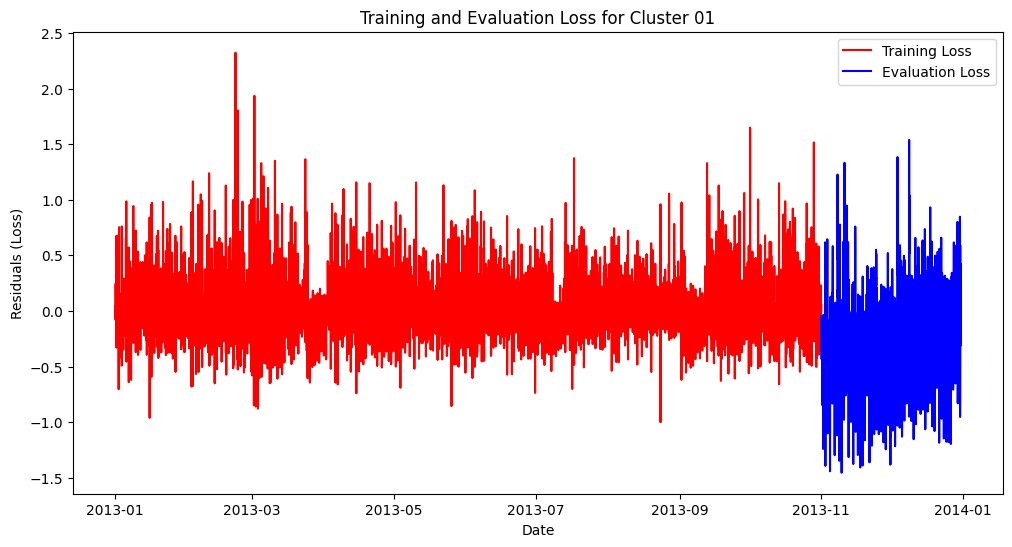

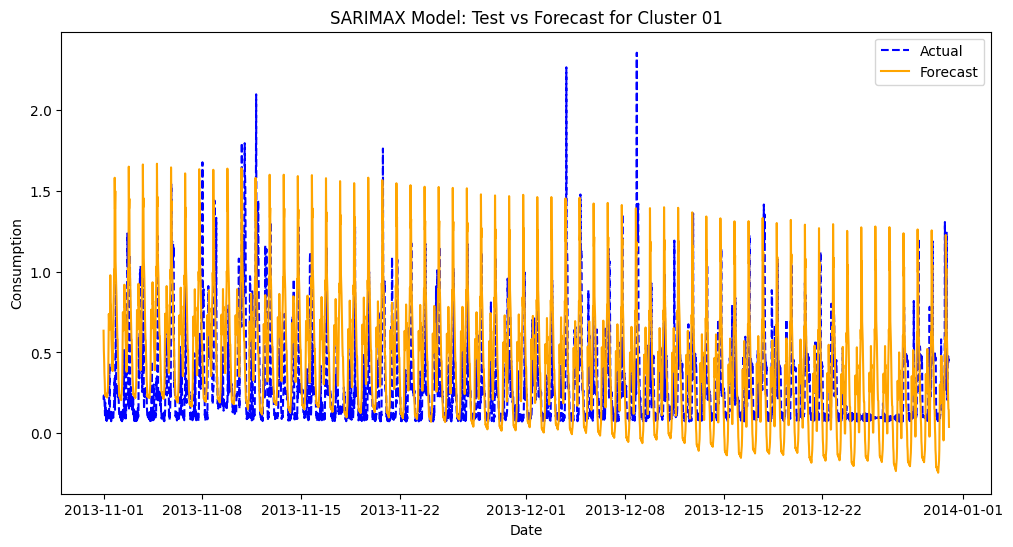

In [ ]:
# Define SARIMAX order and seasonal order
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 48)


# Train and evaluate SARIMAX model for each cluster
results_00, sarimax_00_predicted_values = train_evaluate_sarimax(
    sarimax_cluster_00_temp[:train_end_date],  # Training data
    sarimax_cluster_00_temp[train_end_date:],  # Testing data
    'Cluster 00',
    order,
    seasonal_order,
    scaler_consumption_00
)

results_01, sarimax_01_predicted_values = train_evaluate_sarimax(
    sarimax_cluster_01_temp[:train_end_date],  # Training data
    sarimax_cluster_01_temp[train_end_date:],  # Testing data
    'Cluster 01',
    order,
    seasonal_order,
    scaler_consumption_01
)

results_02, sarimax_02_predicted_values = train_evaluate_sarimax(
    sarimax_cluster_02_temp[:train_end_date],  # Training data
    sarimax_cluster_02_temp[train_end_date:],  # Testing data
    'Cluster 02',
    order,
    seasonal_order,
    scaler_consumption_02
)


## **LSTM Model**

In [ ]:
LSTM_Cluster_00 = std_data_clean[std_data_clean['LCLid'] == 'MAC000002'].copy()
LSTM_Cluster_01 = std_data_clean[std_data_clean['LCLid'] == 'MAC000003'].copy()
LSTM_Cluster_02 = std_data_clean[std_data_clean['LCLid'] == 'MAC000010'].copy()

## **Merging Temperature data for LSTM**



In [ ]:
#Dropping LCLid Column
LSTM_Cluster_00 = LSTM_Cluster_00.drop('LCLid', axis=1)
LSTM_Cluster_01 = LSTM_Cluster_01.drop('LCLid', axis=1)
LSTM_Cluster_02 = LSTM_Cluster_02.drop('LCLid', axis=1)

# Convert 'DateTime' columns to datetime
LSTM_Cluster_00['DateTime'] = pd.to_datetime(LSTM_Cluster_00['DateTime'])
LSTM_Cluster_01['DateTime'] = pd.to_datetime(LSTM_Cluster_01['DateTime'])
LSTM_Cluster_02['DateTime'] = pd.to_datetime(LSTM_Cluster_02['DateTime'])
filtered_weather_data_hh['DateTime'] = pd.to_datetime(filtered_weather_data_hh['DateTime'])
# Merge the Dataframes on DateTime
LSTM_Cluster_00_temp = pd.merge(LSTM_Cluster_00, filtered_weather_data_hh, on='DateTime', how='inner')
LSTM_Cluster_01_temp = pd.merge(LSTM_Cluster_01, filtered_weather_data_hh, on='DateTime', how='inner')
LSTM_Cluster_02_temp = pd.merge(LSTM_Cluster_02, filtered_weather_data_hh, on='DateTime', how='inner')



In [ ]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predicting only the first column (e.g., Consumption)
    return np.array(X), np.array(y)

def prepare_data(merged_data, sequence_length, train_end_date):
    # Convert train_end_date to a datetime object
    train_end_date = pd.to_datetime(train_end_date)

    # Generate date indices starting from 2013-01-01 with half-hourly frequency
    date_indices = pd.date_range(start='2013-01-01', periods=len(merged_data), freq='30T')

    # Find the index corresponding to the train_end_date
    train_end_index = np.searchsorted(date_indices, train_end_date)

    # Split the data into training and testing sets based on the train_end_index
    train_data = merged_data[:train_end_index]
    test_data = merged_data[train_end_index:]

    # Extract timestamps for plotting
    train_timestamps = date_indices[:train_end_index]
    test_timestamps = date_indices[train_end_index:]

    # Drop the 'DateTime' column if it exists
    if 'DateTime' in train_data.columns:
        train_data = train_data.drop(columns=['DateTime'])
        test_data = test_data.drop(columns=['DateTime'])

    # Separate the consumption and temperature columns
    consumption_train_data = train_data.drop(columns=['Temp'])
    consumption_test_data = test_data.drop(columns=['Temp'])

    temp_train_data = train_data[['Temp']]
    temp_test_data = test_data[['Temp']]

    # Normalize the consumption data separately using MinMaxScaler
    scaler_consumption = MinMaxScaler()
    consumption_train_data = scaler_consumption.fit_transform(np.array(consumption_train_data, dtype=np.float32))
    consumption_test_data = scaler_consumption.transform(np.array(consumption_test_data, dtype=np.float32))

    # Normalize the temperature data separately using MinMaxScaler
    scaler_temperature = MinMaxScaler()
    temp_train_data = scaler_temperature.fit_transform(np.array(temp_train_data, dtype=np.float32))
    temp_test_data = scaler_temperature.transform(np.array(temp_test_data, dtype=np.float32))

    # Combine the separately normalized data
    train_data_combined = np.hstack((consumption_train_data, temp_train_data))
    test_data_combined = np.hstack((consumption_test_data, temp_test_data))

    # Create sequences for the combined training and testing sets
    X_train, y_train = create_sequences(train_data_combined, sequence_length)
    X_test, y_test = create_sequences(test_data_combined, sequence_length)

    return X_train, X_test, y_train, y_test, scaler_consumption, scaler_temperature, test_timestamps


In [ ]:

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_evaluate_lstm(X_train, X_test, y_train, y_test, scaler_consumption, cluster_name, test_timestamps, epochs=10, batch_size=32):
    try:
        # Ensure all data is numerical
        X_train = np.array(X_train, dtype=np.float32)
        X_test = np.array(X_test, dtype=np.float32)
        y_train = np.array(y_train, dtype=np.float32)
        y_test = np.array(y_test, dtype=np.float32)

        # Debugging: Print data shapes
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")

        # Ensure input shape is correct for the LSTM
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_lstm_model(input_shape)

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

        # Make predictions
        y_pred = model.predict(X_test)

        # Rescale predictions and test values back to the original scale using the scaler for consumption
        y_pred_rescaled = scaler_consumption.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scaler_consumption.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Calculate metrics
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

        print(f'{cluster_name} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

        # Plot test and forecasted values with timestamps
        plt.figure(figsize=(12, 6))
        plt.plot(test_timestamps[len(test_timestamps) - len(y_test_rescaled):], y_test_rescaled, label='Test')
        plt.plot(test_timestamps[len(test_timestamps) - len(y_pred_rescaled):], y_pred_rescaled, label='Forecast')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.title(f'LSTM Model Test vs Forecast for {cluster_name}')
        plt.legend()
        plt.show()

        # Plot training and evaluation loss
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss for {cluster_name}')
        plt.legend()
        plt.show()

        return model, y_pred_rescaled, history

    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None, None


In [ ]:
SEQUENCE_LENGTH =48
train_end_date = '2013-10-31 23:30:00'
# Splitting the data
Lstm_X_train_00, Lstm_X_test_00, Lstm_y_train_00, Lstm_y_test_00, scaler_cons_00, scaler_temp_00, test_timestamps_00 = prepare_data(LSTM_Cluster_00_temp, SEQUENCE_LENGTH, train_end_date)
Lstm_X_train_01, Lstm_X_test_01, Lstm_y_train_01, Lstm_y_test_01, scaler_cons_01, scaler_temp_01, test_timestamps_01 = prepare_data(LSTM_Cluster_01_temp, SEQUENCE_LENGTH, train_end_date)
Lstm_X_train_02, Lstm_X_test_02, Lstm_y_train_02, Lstm_y_test_02, scaler_cons_02, scaler_temp_02, test_timestamps_02 = prepare_data(LSTM_Cluster_02_temp, SEQUENCE_LENGTH, train_end_date)

# Evaluating the data
model_00, Lstm_predicted_values_00, history_00 = train_evaluate_lstm(Lstm_X_train_00, Lstm_X_test_00, Lstm_y_train_00, Lstm_y_test_00, scaler_cons_00, 'Cluster 00', test_timestamps_00, epochs=20, batch_size=32)
model_01, Lstm_predicted_values_01, history_01 = train_evaluate_lstm(Lstm_X_train_01, Lstm_X_test_01, Lstm_y_train_01, Lstm_y_test_01, scaler_cons_01, 'Cluster 01', test_timestamps_01, epochs=20, batch_size=32)
model_02, Lstm_predicted_values_02, history_02 = train_evaluate_lstm(Lstm_X_train_02, Lstm_X_test_02, Lstm_y_train_02, Lstm_y_test_02, scaler_cons_02, 'Cluster 02', test_timestamps_02, epochs=20, batch_size=32)